In [6]:
import cv2
import mediapipe as mp
import os

import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
#import seaborn as sns

import argparse
import itertools
import copy

import pickle

import tensorflow as tf
from tensorflow import keras
from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

##### Labels for prediction

In [7]:
labels = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
numLabels = len(labels)

## Capturing landmarks for building dataset
First two cells are for initialization of CSVs

In [3]:
# num_coords = len(results.right_hand_landmarks.landmark)
# landmarks = ['label']
# for val in range(1, num_coords+1):
#     landmarks += ['x{}'.format(val), 'y{}'.format(val), 'z{}'.format(val), 'v{}'.format(val)]
    
# print(landmarks)

In [4]:
# with open('hol_landmarks_right.csv', mode='w', newline='') as f:
#                             csv_writer = csv.writer(f, delimiter=',', quotechar='"')
#                             csv_writer.writerow(landmarks)
# with open('hol_landmarks_left.csv', mode='w', newline='') as f:
#                             csv_writer = csv.writer(f, delimiter=',', quotechar='"')
#                             csv_writer.writerow(landmarks)

In [5]:
def write_to_csv_right(label,landmarks):
    path = 'hol_landmarks_right.csv'
    with open(path, 'a', newline="") as f:
        r_row = csv.writer(f)
        r_row.writerow([label, *landmarks])
    return

def write_to_csv_left(label,landmarks):
    path = 'hol_landmarks_left.csv'
    with open(path, 'a', newline="") as f:
        l_row = csv.writer(f)
        l_row.writerow([label, *landmarks])
    return

In [6]:
def getLabel(key):
    label = chr(key)
    return label

In [12]:
def preprocess_landmark(landmarks):
    temp_landmarks = copy.deepcopy(landmarks)
    base_x, base_y = 0, 0
    for index, landmark_point in enumerate(temp_landmarks):
        if index == 0:
            base_x, base_y = landmark_point[0], landmark_point[1]
        temp_landmarks[index][0] = temp_landmarks[index][0] - base_x
        temp_landmarks[index][1] = temp_landmarks[index][1] - base_y

    temp_landmarks = list(itertools.chain.from_iterable(temp_landmarks))
    max_value = max(list(map(abs, temp_landmarks)))

    def normalize_(n):
        return n / max_value
    temp_landmarks = list(map(normalize_, temp_landmarks))
    
    return temp_landmarks

In [11]:
def calc_landmark_list(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_point = []

    # Keypoint
    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)
        # landmark_z = landmark.z

        landmark_point.append([landmark_x, landmark_y])

    return landmark_point

In [44]:
mphands = mp.solutions.hands
hands = mphands.Hands(
        static_image_mode=True,
        max_num_hands=1,
        min_detection_confidence=0.7,
        min_tracking_confidence=0.5,
    )
mp_drawing = mp.solutions.drawing_utils
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 960)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 540)

_, frame = cap.read()
h, w, c = frame.shape

index = 0

while True:
    key=cv2.waitKey(2)
    if key != -1:
        label=getLabel(key).upper()
        #print(label)
    _, frame = cap.read()
    img_debug=copy.deepcopy(frame)
    framergb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    framergb.flags.writeable = True
    result = hands.process(framergb)
    framergb.flags.writeable = False
    hand_landmarks = result.multi_hand_landmarks
    if hand_landmarks:
        for handLMs in hand_landmarks:
            x_max = 0
            y_max = 0
            x_min = w
            y_min = h
            #print(handLMs)
            landmarks = calc_landmark_list(framergb, handLMs)
            #print(landmarks)
            pre_processed_landmarks = preprocess_landmark(landmarks)
            #print(pre_processed_landmarks)
            try:
                temp_key=getLabel(cv2.waitKey(2)).upper()
                if temp_key == label and temp_key != '0':
                    write_to_csv_right(ord(label)-97,pre_processed_landmarks)
                    index += 1
                    if index == 300:
                        print(f'Data Max for {label}')
                        index = 0
            except:
                pass
            for lm in handLMs.landmark:
                x, y = int(lm.x * w), int(lm.y * h)
                if x > x_max:
                    x_max = x
                if x < x_min:
                    x_min = x
                if y > y_max:
                    y_max = y
                if y < y_min:
                    y_min = y
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            mp_drawing.draw_landmarks(frame, handLMs, mphands.HAND_CONNECTIONS)
    cv2.imshow("Get landmarks for dataset", frame)
    if cv2.waitKey(10) & 0xFF == ord('0'):
            break
cap.release()
cv2.destroyAllWindows()

Data Max for A
Data Max for B
Data Max for C
Data Max for D
Data Max for E
Data Max for F
Data Max for G
Data Max for H
Data Max for I
Data Max for J
Data Max for K
Data Max for L
Data Max for M
Data Max for N
Data Max for O
Data Max for P
Data Max for Q
Data Max for R
Data Max for S
Data Max for T
Data Max for U
Data Max for V
Data Max for W
Data Max for X
Data Max for Y
Data Max for Z


# Training Model (For Testing) using SciKit

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [20]:
df = pd.read_csv('hol_landmarks.csv')

In [12]:
X = df.drop('label', axis=1)
y = df['label']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [16]:
pipelines = {
    'lr':make_pipeline(StandardScaler(), LogisticRegression()),
    'rc':make_pipeline(StandardScaler(), RidgeClassifier()),
    'rf':make_pipeline(StandardScaler(), RandomForestClassifier()),
    'gb':make_pipeline(StandardScaler(), GradientBoostingClassifier())
}

In [17]:
list(pipelines.values())[0]

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [ ]:
fit_models = {}
for algo, pipeline in pipelines.items():
    model = pipeline.fit(X_train.values, y_train)
    fit_models[algo] = model

In [19]:
fit_models

{'lr': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression', LogisticRegression())]),
 'rc': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('ridgeclassifier', RidgeClassifier())]),
 'rf': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier', RandomForestClassifier())]),
 'gb': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('gradientboostingclassifier', GradientBoostingClassifier())])}

In [ ]:
fit_models['rf'].predict(X_test)

In [ ]:
for algo, model in fit_models.items():
    yhat = model.predict(X_test)
    print(algo, accuracy_score(y_test, yhat))

In [23]:
with open('sign_language_gb.pkl', 'wb') as f:
    pickle.dump(fit_models['gb'], f)

# Testing Detections

### Detection for pickle model

In [22]:
with open('sign_language_gb.pkl', 'rb') as f:
    model = pickle.load(f)

In [13]:
cap = cv2.VideoCapture(0)
# Initiate holistic model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    
    while cap.isOpened():
        ret, frame = cap.read()
        
        # Recolor Feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        # Make Detections
        results = holistic.process(image)
        
        # Recolor image back to BGR for rendering
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                                 )
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                                 mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                                 )
        
        try:
            #Extract right hand landmarks
            sign_right = results.right_hand_landmarks.landmark
            sign_right_row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] for landmark in sign_right]).flatten())
            testX = pd.DataFrame([sign_right_row])
            sign_language_class = model.predict(testX)[0]
            sign_language_prob = model.predict_proba(testX)[0]
            image = cv2.putText(image, "{}".format(sign_language_class), (90,400), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,0), 5)
            #print(sign_language_class, sign_language_prob)
        except:
            pass
                        
        cv2.imshow('Hand Model Frames', image)

        if cv2.waitKey(10) & 0xFF == ord('x'):
            break

cap.release()
cv2.destroyAllWindows()

NameError: name 'mp_holistic' is not defined

### Detection for TensorFlowLite Model

In [8]:
class KeyPointClassifier(object):
    def __init__(
        self,
        model_path='sign_lang_detect_right.tflite',
        num_threads=1,
    ):
        self.interpreter = tf.lite.Interpreter(model_path=model_path,
                                               num_threads=num_threads)

        self.interpreter.allocate_tensors()
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()

    def __call__(
        self,
        landmark_list,
    ):
        input_details_tensor_index = self.input_details[0]['index']
        self.interpreter.set_tensor(
            input_details_tensor_index,
            np.array([landmark_list], dtype=np.float32))
        self.interpreter.invoke()

        output_details_tensor_index = self.output_details[0]['index']

        result = self.interpreter.get_tensor(output_details_tensor_index)

        result_index = np.argmax(np.squeeze(result))

        return result_index

In [9]:
keypoint_classifier = KeyPointClassifier()

In [15]:
mphands = mp.solutions.hands
hands = mphands.Hands(
        static_image_mode=True,
        max_num_hands=1,
        min_detection_confidence=0.7,
        min_tracking_confidence=0.5,
    )
mp_drawing = mp.solutions.drawing_utils
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 960)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 540)

_, frame = cap.read()
h, w, c = frame.shape

index = 0

while True:
    _, frame = cap.read()
    img_debug=copy.deepcopy(frame)
    framergb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    framergb.flags.writeable = True
    result = hands.process(framergb)
    framergb.flags.writeable = False
    hand_landmarks = result.multi_hand_landmarks
    if hand_landmarks:
        for handLMs in hand_landmarks:
            x_max = 0
            y_max = 0
            x_min = w
            y_min = h
            #print(handLMs, "BLOOP")
            landmarks = calc_landmark_list(framergb, handLMs)
            #print(landmarks, "BLOOP")
            pre_processed_landmarks = preprocess_landmark(landmarks)
            #print(pre_processed_landmarks, "BLOOP")
            sign_language_class = keypoint_classifier(pre_processed_landmarks)
            #print(sign_language_class)
            #sign_language_prob = tf_model.predict_proba(pre_processed_landmarks)
            frame = cv2.putText(frame, "{}".format(labels[sign_language_class]), (90,400), cv2.FONT_HERSHEY_SIMPLEX, 3, (0,0,0), 5)
            #print(sign_language_class, sign_language_prob)
            for lm in handLMs.landmark:
                x, y = int(lm.x * w), int(lm.y * h)
                if x > x_max:
                    x_max = x
                if x < x_min:
                    x_min = x
                if y > y_max:
                    y_max = y
                if y < y_min:
                    y_min = y
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            mp_drawing.draw_landmarks(frame, handLMs, mphands.HAND_CONNECTIONS)
    cv2.imshow("Test", frame)
    if cv2.waitKey(10) & 0xFF == ord('x'):
            break
cap.release()
cv2.destroyAllWindows()

landmark {
  x: 0.5046617984771729
  y: 0.7104360461235046
  z: -2.3022987249987636e-07
}
landmark {
  x: 0.5354771614074707
  y: 0.6012291312217712
  z: -0.00014340328925754875
}
landmark {
  x: 0.5436307191848755
  y: 0.4982713758945465
  z: 0.0074830311350524426
}
landmark {
  x: 0.5167669653892517
  y: 0.4183282256126404
  z: 0.0116628622636199
}
landmark {
  x: 0.4869190752506256
  y: 0.3861144781112671
  z: 0.016625901684165
}
landmark {
  x: 0.48240941762924194
  y: 0.48565250635147095
  z: 0.03625963628292084
}
landmark {
  x: 0.45837733149528503
  y: 0.42600420117378235
  z: 0.02683243155479431
}
landmark {
  x: 0.4764479398727417
  y: 0.4626002609729767
  z: 0.014611786231398582
}
landmark {
  x: 0.4959277808666229
  y: 0.509261965751648
  z: 0.009698208421468735
}
landmark {
  x: 0.4543766379356384
  y: 0.5263515114784241
  z: 0.03412160277366638
}
landmark {
  x: 0.4276588559150696
  y: 0.4683501720428467
  z: 0.024785051122307777
}
landmark {
  x: 0.45405706763267517
  y: 

landmark {
  x: 0.4970996081829071
  y: 0.670657753944397
  z: -2.4686397637196933e-07
}
landmark {
  x: 0.544898271560669
  y: 0.588785707950592
  z: -0.0017477308865636587
}
landmark {
  x: 0.5631417036056519
  y: 0.517126202583313
  z: 0.003277804236859083
}
landmark {
  x: 0.552435040473938
  y: 0.4454934000968933
  z: 0.0040649366565048695
}
landmark {
  x: 0.5217868089675903
  y: 0.4202488660812378
  z: 0.007127194665372372
}
landmark {
  x: 0.5097391605377197
  y: 0.4724791347980499
  z: 0.03908096253871918
}
landmark {
  x: 0.5041062235832214
  y: 0.4250814616680145
  z: 0.01095896027982235
}
landmark {
  x: 0.5143687725067139
  y: 0.4746284484863281
  z: -0.01728791929781437
}
landmark {
  x: 0.5221662521362305
  y: 0.5255113244056702
  z: -0.03052736259996891
}
landmark {
  x: 0.480594277381897
  y: 0.4979710876941681
  z: 0.03467855602502823
}
landmark {
  x: 0.4725175201892853
  y: 0.42837420105934143
  z: 0.0010020039044320583
}
landmark {
  x: 0.486190527677536
  y: 0.491

landmark {
  x: 0.46488863229751587
  y: 0.6766906380653381
  z: -2.1387252502336196e-07
}
landmark {
  x: 0.5150970816612244
  y: 0.5929883718490601
  z: -0.0013352552196010947
}
landmark {
  x: 0.5350053906440735
  y: 0.5167545080184937
  z: 0.005089086014777422
}
landmark {
  x: 0.5257664918899536
  y: 0.4408588409423828
  z: 0.0069077289663255215
}
landmark {
  x: 0.49440866708755493
  y: 0.41576313972473145
  z: 0.01079501397907734
}
landmark {
  x: 0.4783073365688324
  y: 0.4722370207309723
  z: 0.050739534199237823
}
landmark {
  x: 0.47299620509147644
  y: 0.42194846272468567
  z: 0.026685697957873344
}
landmark {
  x: 0.4822782874107361
  y: 0.4717422425746918
  z: -0.0010666783200576901
}
landmark {
  x: 0.4903264343738556
  y: 0.5254011154174805
  z: -0.013811671175062656
}
landmark {
  x: 0.44908401370048523
  y: 0.49384382367134094
  z: 0.047351859509944916
}
landmark {
  x: 0.44390782713890076
  y: 0.4260977506637573
  z: 0.01629611849784851
}
landmark {
  x: 0.4560525417

landmark {
  x: 0.41092801094055176
  y: 0.6971234679222107
  z: -2.1844554964900453e-07
}
landmark {
  x: 0.47151684761047363
  y: 0.627748966217041
  z: -0.000433685549069196
}
landmark {
  x: 0.5028699040412903
  y: 0.5605143308639526
  z: 0.0050269924104213715
}
landmark {
  x: 0.5068594217300415
  y: 0.48170503973960876
  z: 0.004705796483904123
}
landmark {
  x: 0.4806153178215027
  y: 0.43715348839759827
  z: 0.0065079559572041035
}
landmark {
  x: 0.45182788372039795
  y: 0.49608147144317627
  z: 0.04854379594326019
}
landmark {
  x: 0.45927703380584717
  y: 0.4375946819782257
  z: 0.021861495450139046
}
landmark {
  x: 0.4605688154697418
  y: 0.49101847410202026
  z: -0.00584041140973568
}
landmark {
  x: 0.45864298939704895
  y: 0.5509793162345886
  z: -0.01814245991408825
}
landmark {
  x: 0.41984906792640686
  y: 0.5022640824317932
  z: 0.04227668046951294
}
landmark {
  x: 0.42800208926200867
  y: 0.42873990535736084
  z: 0.009316529147326946
}
landmark {
  x: 0.4303792417

landmark {
  x: 0.39049646258354187
  y: 0.7015872001647949
  z: -2.0484122842390207e-07
}
landmark {
  x: 0.45270323753356934
  y: 0.6413756608963013
  z: -0.008722994476556778
}
landmark {
  x: 0.4854457974433899
  y: 0.5723597407341003
  z: -0.006869416683912277
}
landmark {
  x: 0.4898645579814911
  y: 0.49256962537765503
  z: -0.009031958878040314
}
landmark {
  x: 0.47092750668525696
  y: 0.4342401921749115
  z: -0.008268097415566444
}
landmark {
  x: 0.43636614084243774
  y: 0.5052021145820618
  z: 0.0384201817214489
}
landmark {
  x: 0.4423026740550995
  y: 0.4495285749435425
  z: 0.004341410472989082
}
landmark {
  x: 0.4437437057495117
  y: 0.501698911190033
  z: -0.027310946956276894
}
landmark {
  x: 0.44312572479248047
  y: 0.5612255930900574
  z: -0.041346512734889984
}
landmark {
  x: 0.40281474590301514
  y: 0.5109423398971558
  z: 0.03475067391991615
}
landmark {
  x: 0.4120687246322632
  y: 0.43239760398864746
  z: -0.007362766191363335
}
landmark {
  x: 0.41465881466

landmark {
  x: 0.3951385021209717
  y: 0.7602103352546692
  z: -2.3347836020093382e-07
}
landmark {
  x: 0.45521363615989685
  y: 0.6826335191726685
  z: 0.0010774373076856136
}
landmark {
  x: 0.47615277767181396
  y: 0.6011794805526733
  z: 0.009301910176873207
}
landmark {
  x: 0.46878480911254883
  y: 0.52186119556427
  z: 0.012148993089795113
}
landmark {
  x: 0.46872708201408386
  y: 0.466670960187912
  z: 0.016353167593479156
}
landmark {
  x: 0.43148261308670044
  y: 0.5491021275520325
  z: 0.04744978994131088
}
landmark {
  x: 0.4325310289859772
  y: 0.4924294352531433
  z: 0.027907950803637505
}
landmark {
  x: 0.43509602546691895
  y: 0.5376595854759216
  z: 0.006303504575043917
}
landmark {
  x: 0.438088595867157
  y: 0.5955004096031189
  z: -0.003256322583183646
}
landmark {
  x: 0.3979431092739105
  y: 0.5594428777694702
  z: 0.04269721731543541
}
landmark {
  x: 0.40161263942718506
  y: 0.4869197607040405
  z: 0.015292796306312084
}
landmark {
  x: 0.40683144330978394
 

landmark {
  x: 0.4000953137874603
  y: 0.6823031902313232
  z: -2.7940535574089154e-07
}
landmark {
  x: 0.46441543102264404
  y: 0.5963716506958008
  z: 0.0019222409464418888
}
landmark {
  x: 0.48435530066490173
  y: 0.5108279585838318
  z: 0.013106669299304485
}
landmark {
  x: 0.47642260789871216
  y: 0.42663246393203735
  z: 0.01810232736170292
}
landmark {
  x: 0.4738602936267853
  y: 0.36745238304138184
  z: 0.025182051584124565
}
landmark {
  x: 0.43590378761291504
  y: 0.4595324993133545
  z: 0.05983131751418114
}
landmark {
  x: 0.4358011782169342
  y: 0.39983996748924255
  z: 0.036785826086997986
}
landmark {
  x: 0.4382266104221344
  y: 0.4516650140285492
  z: 0.009784514084458351
}
landmark {
  x: 0.43961119651794434
  y: 0.5126239657402039
  z: -0.00254423706792295
}
landmark {
  x: 0.4004702568054199
  y: 0.4727507531642914
  z: 0.05464683473110199
}
landmark {
  x: 0.4018758237361908
  y: 0.3892180621623993
  z: 0.021287163719534874
}
landmark {
  x: 0.4087784886360168

landmark {
  x: 0.4769654870033264
  y: 0.5772796273231506
  z: -1.3394860332027747e-08
}
landmark {
  x: 0.438198059797287
  y: 0.48557305335998535
  z: -0.015393776819109917
}
landmark {
  x: 0.3990829586982727
  y: 0.4164356589317322
  z: -0.011949167586863041
}
landmark {
  x: 0.3597377836704254
  y: 0.37282881140708923
  z: -0.00665323855355382
}
landmark {
  x: 0.33447062969207764
  y: 0.3361409306526184
  z: -0.001042629824951291
}
landmark {
  x: 0.39641720056533813
  y: 0.4210667908191681
  z: 0.019109027460217476
}
landmark {
  x: 0.34355008602142334
  y: 0.4200121760368347
  z: 0.015771660953760147
}
landmark {
  x: 0.30767983198165894
  y: 0.44038641452789307
  z: 0.003414713777601719
}
landmark {
  x: 0.27867382764816284
  y: 0.4613238573074341
  z: -0.0061987945809960365
}
landmark {
  x: 0.4053876996040344
  y: 0.4652443528175354
  z: 0.024437637999653816
}
landmark {
  x: 0.34864869713783264
  y: 0.4736056923866272
  z: 0.02596156857907772
}
landmark {
  x: 0.3116808533

landmark {
  x: 0.302333265542984
  y: 0.9957264065742493
  z: 8.581782253713754e-07
}
landmark {
  x: 0.34633520245552063
  y: 0.8107542395591736
  z: -0.06736990064382553
}
landmark {
  x: 0.3529369831085205
  y: 0.6307305097579956
  z: -0.09782563149929047
}
landmark {
  x: 0.309073269367218
  y: 0.4895869195461273
  z: -0.1120314747095108
}
landmark {
  x: 0.2537094056606293
  y: 0.3852880895137787
  z: -0.12719839811325073
}
landmark {
  x: 0.25229328870773315
  y: 0.6736766695976257
  z: -0.10495256632566452
}
landmark {
  x: 0.1758202165365219
  y: 0.5209603309631348
  z: -0.13429762423038483
}
landmark {
  x: 0.11769157648086548
  y: 0.437762051820755
  z: -0.1545814871788025
}
landmark {
  x: 0.0659220963716507
  y: 0.3728789985179901
  z: -0.1716616004705429
}
landmark {
  x: 0.19180135428905487
  y: 0.7611633539199829
  z: -0.08557333052158356
}
landmark {
  x: 0.10015036910772324
  y: 0.6284352540969849
  z: -0.12170106172561646
}
landmark {
  x: 0.036280691623687744
  y: 0

landmark {
  x: 0.2988433241844177
  y: 0.8092453479766846
  z: 5.904831255065801e-07
}
landmark {
  x: 0.28514501452445984
  y: 0.5689693689346313
  z: 0.0026433805469423532
}
landmark {
  x: 0.2679373025894165
  y: 0.4304330348968506
  z: 0.03859011083841324
}
landmark {
  x: 0.2275865226984024
  y: 0.3521338403224945
  z: 0.06968227028846741
}
landmark {
  x: 0.19142474234104156
  y: 0.29391950368881226
  z: 0.10253506153821945
}
landmark {
  x: 0.288855642080307
  y: 0.4556201696395874
  z: 0.13283538818359375
}
landmark {
  x: 0.2345670461654663
  y: 0.3479674458503723
  z: 0.16470545530319214
}
landmark {
  x: 0.1861170530319214
  y: 0.2759116590023041
  z: 0.1617109626531601
}
landmark {
  x: 0.14184284210205078
  y: 0.22652485966682434
  z: 0.15232403576374054
}
landmark {
  x: 0.2583466172218323
  y: 0.5481796264648438
  z: 0.13302738964557648
}
landmark {
  x: 0.19592571258544922
  y: 0.4325345754623413
  z: 0.1605202555656433
}
landmark {
  x: 0.1388935148715973
  y: 0.35956

landmark {
  x: 0.9141412973403931
  y: 0.6831216812133789
  z: 6.737694207004097e-07
}
landmark {
  x: 0.935469388961792
  y: 0.5194164514541626
  z: 0.014420553110539913
}
landmark {
  x: 0.9269604086875916
  y: 0.4083883464336395
  z: 0.029250673949718475
}
landmark {
  x: 0.9054257869720459
  y: 0.3169311583042145
  z: 0.03228138014674187
}
landmark {
  x: 0.8731290102005005
  y: 0.23135320842266083
  z: 0.03565479815006256
}
landmark {
  x: 0.804265022277832
  y: 0.43042707443237305
  z: 0.12155033648014069
}
landmark {
  x: 0.774825930595398
  y: 0.33587223291397095
  z: 0.15104874968528748
}
landmark {
  x: 0.7585906386375427
  y: 0.27039363980293274
  z: 0.1573527753353119
}
landmark {
  x: 0.746320903301239
  y: 0.22421720623970032
  z: 0.15936599671840668
}
landmark {
  x: 0.7732939124107361
  y: 0.4621843993663788
  z: 0.10692011564970016
}
landmark {
  x: 0.7302069067955017
  y: 0.36622312664985657
  z: 0.14289098978042603
}
landmark {
  x: 0.7079282402992249
  y: 0.2996010

landmark {
  x: 0.4149775207042694
  y: 0.8936110138893127
  z: 7.443035201504244e-07
}
landmark {
  x: 0.46445977687835693
  y: 0.6728636622428894
  z: -0.05430513992905617
}
landmark {
  x: 0.474420428276062
  y: 0.4822923243045807
  z: -0.07305629551410675
}
landmark {
  x: 0.42065826058387756
  y: 0.3503429889678955
  z: -0.08775845915079117
}
landmark {
  x: 0.3612571358680725
  y: 0.2427021563053131
  z: -0.10762257874011993
}
landmark {
  x: 0.3911431133747101
  y: 0.5314673781394958
  z: -0.04131244122982025
}
landmark {
  x: 0.3125162422657013
  y: 0.374600350856781
  z: -0.08007603883743286
}
landmark {
  x: 0.2587701082229614
  y: 0.28671902418136597
  z: -0.12065223604440689
}
landmark {
  x: 0.2144838571548462
  y: 0.21487411856651306
  z: -0.15453016757965088
}
landmark {
  x: 0.33096566796302795
  y: 0.6212151050567627
  z: -0.04664172604680061
}
landmark {
  x: 0.24672815203666687
  y: 0.4570157527923584
  z: -0.10375954955816269
}
landmark {
  x: 0.18603110313415527
  

landmark {
  x: 0.4157818555831909
  y: 0.9303727149963379
  z: 6.415302209461515e-07
}
landmark {
  x: 0.46498310565948486
  y: 0.705910861492157
  z: -0.03269317001104355
}
landmark {
  x: 0.47875648736953735
  y: 0.5144060850143433
  z: -0.027146581560373306
}
landmark {
  x: 0.42479413747787476
  y: 0.3835464119911194
  z: -0.021874483674764633
}
landmark {
  x: 0.3594743311405182
  y: 0.2877296805381775
  z: -0.018917223438620567
}
landmark {
  x: 0.3926199674606323
  y: 0.5637123584747314
  z: 0.039375536143779755
}
landmark {
  x: 0.31834548711776733
  y: 0.4080698490142822
  z: 0.032270077615976334
}
landmark {
  x: 0.26921316981315613
  y: 0.328474760055542
  z: 0.009631908498704433
}
landmark {
  x: 0.22133907675743103
  y: 0.2635855972766876
  z: -0.012562516145408154
}
landmark {
  x: 0.3356027603149414
  y: 0.643537163734436
  z: 0.03555253893136978
}
landmark {
  x: 0.25324299931526184
  y: 0.4974276125431061
  z: 0.015127668157219887
}
landmark {
  x: 0.19200319051742554

 BLOOP
[[416, 518], [461, 393], [472, 291], [427, 214], [367, 160], [385, 310], [315, 227], [268, 185], [222, 150], [334, 354], [251, 274], [193, 222], [144, 182], [290, 401], [209, 329], [152, 277], [103, 232], [250, 455], [164, 401], [111, 364], [67, 320]] BLOOP
[0.0, 0.0, 0.12228260869565218, -0.33967391304347827, 0.15217391304347827, -0.6168478260869565, 0.029891304347826088, -0.8260869565217391, -0.1331521739130435, -0.9728260869565217, -0.08423913043478261, -0.5652173913043478, -0.27445652173913043, -0.7907608695652174, -0.40217391304347827, -0.904891304347826, -0.5271739130434783, -1.0, -0.22282608695652173, -0.44565217391304346, -0.4483695652173913, -0.6630434782608695, -0.6059782608695652, -0.8043478260869565, -0.7391304347826086, -0.9130434782608695, -0.3423913043478261, -0.3179347826086957, -0.5625, -0.5135869565217391, -0.717391304347826, -0.654891304347826, -0.8505434782608695, -0.7771739130434783, -0.45108695652173914, -0.17119565217391305, -0.6847826086956522, -0.3179347

landmark {
  x: 0.45361030101776123
  y: 0.9413855075836182
  z: 5.037704795540776e-07
}
landmark {
  x: 0.4886188209056854
  y: 0.7350300550460815
  z: -0.023529792204499245
}
landmark {
  x: 0.49604445695877075
  y: 0.5733106136322021
  z: -0.015754319727420807
}
landmark {
  x: 0.45228832960128784
  y: 0.45531994104385376
  z: -0.00948968343436718
}
landmark {
  x: 0.3970957100391388
  y: 0.3704609274864197
  z: -0.00449334317818284
}
landmark {
  x: 0.41025108098983765
  y: 0.5993258357048035
  z: 0.052190396934747696
}
landmark {
  x: 0.34198376536369324
  y: 0.4687640070915222
  z: 0.05160512402653694
}
landmark {
  x: 0.29905709624290466
  y: 0.41013479232788086
  z: 0.032156217843294144
}
landmark {
  x: 0.25682157278060913
  y: 0.3627494275569916
  z: 0.01306427177041769
}
landmark {
  x: 0.3641399145126343
  y: 0.6716581583023071
  z: 0.04992148280143738
}
landmark {
  x: 0.28560692071914673
  y: 0.5444144010543823
  z: 0.04034692049026489
}
landmark {
  x: 0.2322214245796203

 BLOOP
[[440, 499], [476, 391], [486, 307], [443, 242], [394, 198], [407, 325], [344, 260], [304, 231], [265, 209], [361, 363], [291, 298], [241, 258], [201, 229], [323, 402], [253, 345], [206, 305], [168, 269], [289, 449], [221, 404], [178, 373], [142, 336]] BLOOP
[0.0, 0.0, 0.11960132890365449, -0.3588039867109635, 0.15282392026578073, -0.6378737541528239, 0.009966777408637873, -0.8538205980066446, -0.15282392026578073, -1.0, -0.10963455149501661, -0.5780730897009967, -0.31893687707641194, -0.7940199335548173, -0.45182724252491696, -0.8903654485049833, -0.5813953488372093, -0.9634551495016611, -0.26245847176079734, -0.45182724252491696, -0.4950166112956811, -0.6677740863787376, -0.6611295681063123, -0.8006644518272426, -0.7940199335548173, -0.8970099667774086, -0.38870431893687707, -0.3222591362126246, -0.6212624584717608, -0.5116279069767442, -0.7774086378737541, -0.6445182724252492, -0.9036544850498339, -0.7641196013289037, -0.5016611295681063, -0.16611295681063123, -0.727574750830

landmark {
  x: 0.49848753213882446
  y: 0.8485774993896484
  z: 6.519153430417646e-07
}
landmark {
  x: 0.5359753370285034
  y: 0.6480852961540222
  z: -0.0066892593167722225
}
landmark {
  x: 0.543174147605896
  y: 0.5054199695587158
  z: 0.01699991524219513
}
landmark {
  x: 0.5013128519058228
  y: 0.4097970724105835
  z: 0.033507559448480606
}
landmark {
  x: 0.4543781280517578
  y: 0.3397032618522644
  z: 0.049232836812734604
}
landmark {
  x: 0.4703027904033661
  y: 0.5554635524749756
  z: 0.13851284980773926
}
landmark {
  x: 0.4285854995250702
  y: 0.4664851129055023
  z: 0.16822907328605652
}
landmark {
  x: 0.4053744375705719
  y: 0.4207422137260437
  z: 0.16002336144447327
}
landmark {
  x: 0.38518622517585754
  y: 0.3903779983520508
  z: 0.14687420427799225
}
landmark {
  x: 0.4251750409603119
  y: 0.6216446161270142
  z: 0.13516251742839813
}
landmark {
  x: 0.37550175189971924
  y: 0.5293054580688477
  z: 0.1541859358549118
}
landmark {
  x: 0.34674039483070374
  y: 0.467

landmark {
  x: 0.5200719237327576
  y: 0.790880560874939
  z: 5.226629582466558e-07
}
landmark {
  x: 0.556468665599823
  y: 0.5963579416275024
  z: -0.01490249764174223
}
landmark {
  x: 0.5602812170982361
  y: 0.4558408260345459
  z: -0.0017508446471765637
}
landmark {
  x: 0.5202713012695312
  y: 0.37934839725494385
  z: 0.00224899360910058
}
landmark {
  x: 0.47368893027305603
  y: 0.3245713710784912
  z: 0.004874864127486944
}
landmark {
  x: 0.4942171573638916
  y: 0.49663683772087097
  z: 0.13193197548389435
}
landmark {
  x: 0.45215949416160583
  y: 0.42101162672042847
  z: 0.1390659660100937
}
landmark {
  x: 0.4376406669616699
  y: 0.3905712962150574
  z: 0.10996834188699722
}
landmark {
  x: 0.4364148676395416
  y: 0.3866182565689087
  z: 0.08529239892959595
}
landmark {
  x: 0.4517117440700531
  y: 0.572006106376648
  z: 0.12509457767009735
}
landmark {
  x: 0.40264493227005005
  y: 0.4654071033000946
  z: 0.11399685591459274
}
landmark {
  x: 0.38734227418899536
  y: 0.43

 BLOOP
[[515, 408], [550, 315], [557, 247], [523, 200], [478, 172], [484, 254], [445, 213], [431, 196], [432, 202], [444, 289], [399, 228], [390, 213], [401, 226], [412, 317], [364, 265], [355, 246], [372, 256], [380, 353], [339, 317], [327, 297], [340, 287]] BLOOP
[0.0, 0.0, 0.1483050847457627, -0.3940677966101695, 0.17796610169491525, -0.6822033898305084, 0.03389830508474576, -0.8813559322033898, -0.15677966101694915, -1.0, -0.13135593220338984, -0.652542372881356, -0.2966101694915254, -0.826271186440678, -0.3559322033898305, -0.8983050847457628, -0.3516949152542373, -0.8728813559322034, -0.3008474576271186, -0.5042372881355932, -0.4915254237288136, -0.7627118644067796, -0.5296610169491526, -0.826271186440678, -0.4830508474576271, -0.7711864406779662, -0.4364406779661017, -0.3855932203389831, -0.6398305084745762, -0.6059322033898306, -0.6779661016949152, -0.6864406779661016, -0.6059322033898306, -0.6440677966101694, -0.5720338983050848, -0.2330508474576271, -0.7457627118644068, -0.38

landmark {
  x: 0.4881272614002228
  y: 0.7123562097549438
  z: 2.5196473529831565e-07
}
landmark {
  x: 0.5285661220550537
  y: 0.5485612154006958
  z: -0.0025337361730635166
}
landmark {
  x: 0.5410969257354736
  y: 0.43614619970321655
  z: 0.013406588695943356
}
landmark {
  x: 0.5130678415298462
  y: 0.35874414443969727
  z: 0.019156597554683685
}
landmark {
  x: 0.4669203460216522
  y: 0.31736505031585693
  z: 0.02449049986898899
}
landmark {
  x: 0.47447705268859863
  y: 0.4470806121826172
  z: 0.1258821189403534
}
landmark {
  x: 0.4400218725204468
  y: 0.37958115339279175
  z: 0.11893481761217117
}
landmark {
  x: 0.4379021227359772
  y: 0.3664555549621582
  z: 0.07808864861726761
}
landmark {
  x: 0.44077759981155396
  y: 0.38620027899742126
  z: 0.0497576966881752
}
landmark {
  x: 0.435669869184494
  y: 0.5154076218605042
  z: 0.11920586228370667
}
landmark {
  x: 0.40008753538131714
  y: 0.4030831754207611
  z: 0.09273090958595276
}
landmark {
  x: 0.4028717577457428
  y: 0

landmark {
  x: 0.4695585072040558
  y: 0.6898348331451416
  z: 7.559692249969885e-08
}
landmark {
  x: 0.5160735845565796
  y: 0.5388284921646118
  z: 0.00580610940232873
}
landmark {
  x: 0.5252388715744019
  y: 0.4362296164035797
  z: 0.02925102785229683
}
landmark {
  x: 0.4945547580718994
  y: 0.36081457138061523
  z: 0.04199506342411041
}
landmark {
  x: 0.45623940229415894
  y: 0.32912811636924744
  z: 0.05766944959759712
}
landmark {
  x: 0.46828728914260864
  y: 0.4514617919921875
  z: 0.14431877434253693
}
landmark {
  x: 0.4412250816822052
  y: 0.39346155524253845
  z: 0.14229463040828705
}
landmark {
  x: 0.4519752562046051
  y: 0.4029642343521118
  z: 0.11255162954330444
}
landmark {
  x: 0.4554764926433563
  y: 0.41671743988990784
  z: 0.0946493148803711
}
landmark {
  x: 0.43044188618659973
  y: 0.5140013694763184
  z: 0.13978900015354156
}
landmark {
  x: 0.4051452875137329
  y: 0.4150710999965668
  z: 0.11563069373369217
}
landmark {
  x: 0.4266313314437866
  y: 0.4402

landmark {
  x: 0.4613032937049866
  y: 0.6129529476165771
  z: -1.0028971075826121e-07
}
landmark {
  x: 0.5033590197563171
  y: 0.48204708099365234
  z: 0.029492493718862534
}
landmark {
  x: 0.5126860737800598
  y: 0.41072309017181396
  z: 0.06287238746881485
}
landmark {
  x: 0.49090540409088135
  y: 0.33890819549560547
  z: 0.08329683542251587
}
landmark {
  x: 0.46043822169303894
  y: 0.31213223934173584
  z: 0.10453271120786667
}
landmark {
  x: 0.4643920361995697
  y: 0.42309263348579407
  z: 0.14053919911384583
}
landmark {
  x: 0.4333117604255676
  y: 0.3549915552139282
  z: 0.15099826455116272
}
landmark {
  x: 0.44166165590286255
  y: 0.3560110628604889
  z: 0.13243624567985535
}
landmark {
  x: 0.44927239418029785
  y: 0.3799628019332886
  z: 0.11970134824514389
}
landmark {
  x: 0.4301551580429077
  y: 0.4631974399089813
  z: 0.12938641011714935
}
landmark {
  x: 0.40514788031578064
  y: 0.36812686920166016
  z: 0.1249881312251091
}
landmark {
  x: 0.4197920858860016
  y:

landmark {
  x: 0.4712432026863098
  y: 0.6426151990890503
  z: -2.839131241216819e-07
}
landmark {
  x: 0.5157958269119263
  y: 0.5289771556854248
  z: 0.02053952030837536
}
landmark {
  x: 0.5236882567405701
  y: 0.44656023383140564
  z: 0.04264260455965996
}
landmark {
  x: 0.4925273060798645
  y: 0.36585307121276855
  z: 0.0560082271695137
}
landmark {
  x: 0.46279099583625793
  y: 0.3406590223312378
  z: 0.07167613506317139
}
landmark {
  x: 0.4639437198638916
  y: 0.43780404329299927
  z: 0.09805142134428024
}
landmark {
  x: 0.4455704092979431
  y: 0.3733845353126526
  z: 0.10171496868133545
}
landmark {
  x: 0.46220070123672485
  y: 0.41253823041915894
  z: 0.09218572825193405
}
landmark {
  x: 0.4712499976158142
  y: 0.44286492466926575
  z: 0.08811838179826736
}
landmark {
  x: 0.4304001033306122
  y: 0.47128626704216003
  z: 0.091377854347229
}
landmark {
  x: 0.4136432707309723
  y: 0.40379345417022705
  z: 0.09061852842569351
}
landmark {
  x: 0.43707457184791565
  y: 0.45

 BLOOP
[[462, 347], [503, 274], [509, 232], [483, 195], [456, 175], [455, 230], [421, 191], [416, 178], [413, 176], [424, 257], [399, 202], [413, 212], [426, 233], [396, 273], [375, 228], [392, 243], [405, 262], [360, 289], [347, 256], [363, 267], [379, 283]] BLOOP
[0.0, 0.0, 0.23837209302325582, -0.42441860465116277, 0.27325581395348836, -0.6686046511627907, 0.12209302325581395, -0.8837209302325582, -0.03488372093023256, -1.0, -0.040697674418604654, -0.6802325581395349, -0.23837209302325582, -0.9069767441860465, -0.26744186046511625, -0.9825581395348837, -0.28488372093023256, -0.9941860465116279, -0.22093023255813954, -0.5232558139534884, -0.36627906976744184, -0.8430232558139535, -0.28488372093023256, -0.7848837209302325, -0.20930232558139536, -0.6627906976744186, -0.38372093023255816, -0.43023255813953487, -0.5058139534883721, -0.6918604651162791, -0.4069767441860465, -0.6046511627906976, -0.3313953488372093, -0.4941860465116279, -0.5930232558139535, -0.3372093023255814, -0.66860465

landmark {
  x: 0.4824286997318268
  y: 0.7226582169532776
  z: 6.047415013199497e-07
}
landmark {
  x: 0.5308657884597778
  y: 0.5640838742256165
  z: 0.005499912425875664
}
landmark {
  x: 0.5461573600769043
  y: 0.46488919854164124
  z: 0.03141200542449951
}
landmark {
  x: 0.5246506333351135
  y: 0.38022860884666443
  z: 0.05184043571352959
}
landmark {
  x: 0.5047208070755005
  y: 0.3009415864944458
  z: 0.07191678881645203
}
landmark {
  x: 0.4807576835155487
  y: 0.4773204028606415
  z: 0.11535836011171341
}
landmark {
  x: 0.44960761070251465
  y: 0.3704301714897156
  z: 0.15026803314685822
}
landmark {
  x: 0.43054133653640747
  y: 0.3147527575492859
  z: 0.1527336835861206
}
landmark {
  x: 0.40888628363609314
  y: 0.26618123054504395
  z: 0.14703039824962616
}
landmark {
  x: 0.44114601612091064
  y: 0.5226688981056213
  z: 0.11223646998405457
}
landmark {
  x: 0.4033234417438507
  y: 0.40835610032081604
  z: 0.14095968008041382
}
landmark {
  x: 0.3789961040019989
  y: 0.33

landmark {
  x: 0.4835362434387207
  y: 0.7359298467636108
  z: 4.928008934257377e-07
}
landmark {
  x: 0.5299018621444702
  y: 0.581789493560791
  z: 0.0068780905567109585
}
landmark {
  x: 0.545318603515625
  y: 0.48299551010131836
  z: 0.031200813129544258
}
landmark {
  x: 0.5253598093986511
  y: 0.3984483778476715
  z: 0.05020962283015251
}
landmark {
  x: 0.5038046836853027
  y: 0.32533323764801025
  z: 0.06896266341209412
}
landmark {
  x: 0.4808761477470398
  y: 0.49743303656578064
  z: 0.10729792714118958
}
landmark {
  x: 0.4489716589450836
  y: 0.3931499719619751
  z: 0.13687805831432343
}
landmark {
  x: 0.42871445417404175
  y: 0.3363841772079468
  z: 0.1372530460357666
}
landmark {
  x: 0.40620964765548706
  y: 0.28857743740081787
  z: 0.1311984807252884
}
landmark {
  x: 0.4425181746482849
  y: 0.5401415824890137
  z: 0.10287578403949738
}
landmark {
  x: 0.40476658940315247
  y: 0.4264502227306366
  z: 0.1269223690032959
}
landmark {
  x: 0.3815164566040039
  y: 0.35407

landmark {
  x: 0.4937369227409363
  y: 0.751987099647522
  z: 5.453792368825816e-07
}
landmark {
  x: 0.5381401777267456
  y: 0.5976223945617676
  z: -0.0038025337271392345
}
landmark {
  x: 0.5525268316268921
  y: 0.49711132049560547
  z: 0.014103732071816921
}
landmark {
  x: 0.5313978791236877
  y: 0.41726112365722656
  z: 0.026873484253883362
}
landmark {
  x: 0.5073707103729248
  y: 0.3406306803226471
  z: 0.038737405091524124
}
landmark {
  x: 0.4853917062282562
  y: 0.5030941367149353
  z: 0.09512489289045334
}
landmark {
  x: 0.451449453830719
  y: 0.3975539803504944
  z: 0.11916857957839966
}
landmark {
  x: 0.4293641448020935
  y: 0.34309154748916626
  z: 0.11496591567993164
}
landmark {
  x: 0.405654639005661
  y: 0.2987271547317505
  z: 0.1055685505270958
}
landmark {
  x: 0.44778650999069214
  y: 0.5524033308029175
  z: 0.09119931608438492
}
landmark {
  x: 0.40976446866989136
  y: 0.4402649402618408
  z: 0.10898704081773758
}
landmark {
  x: 0.38324403762817383
  y: 0.36

 BLOOP
[[477, 403], [517, 319], [532, 263], [514, 216], [487, 175], [467, 267], [435, 211], [413, 182], [391, 159], [432, 292], [395, 233], [369, 195], [349, 167], [401, 317], [366, 262], [343, 224], [324, 189], [370, 346], [336, 303], [315, 275], [299, 242]] BLOOP
[0.0, 0.0, 0.16393442622950818, -0.3442622950819672, 0.22540983606557377, -0.5737704918032787, 0.15163934426229508, -0.7663934426229508, 0.040983606557377046, -0.9344262295081968, -0.040983606557377046, -0.5573770491803278, -0.1721311475409836, -0.7868852459016393, -0.26229508196721313, -0.9057377049180327, -0.3524590163934426, -1.0, -0.18442622950819673, -0.45491803278688525, -0.3360655737704918, -0.6967213114754098, -0.4426229508196721, -0.8524590163934426, -0.5245901639344263, -0.9672131147540983, -0.3114754098360656, -0.3524590163934426, -0.45491803278688525, -0.5778688524590164, -0.5491803278688525, -0.7336065573770492, -0.6270491803278688, -0.8770491803278688, -0.4385245901639344, -0.2336065573770492, -0.57786885245901

[[480, 389], [517, 306], [529, 248], [510, 201], [478, 162], [466, 253], [430, 198], [405, 169], [382, 149], [432, 280], [394, 224], [367, 189], [347, 159], [404, 307], [367, 254], [342, 217], [320, 181], [375, 338], [332, 307], [302, 287], [277, 261]] BLOOP
[0.0, 0.0, 0.15416666666666667, -0.3458333333333333, 0.20416666666666666, -0.5875, 0.125, -0.7833333333333333, -0.008333333333333333, -0.9458333333333333, -0.058333333333333334, -0.5666666666666667, -0.20833333333333334, -0.7958333333333333, -0.3125, -0.9166666666666666, -0.4083333333333333, -1.0, -0.2, -0.45416666666666666, -0.35833333333333334, -0.6875, -0.4708333333333333, -0.8333333333333334, -0.5541666666666667, -0.9583333333333334, -0.31666666666666665, -0.3416666666666667, -0.4708333333333333, -0.5625, -0.575, -0.7166666666666667, -0.6666666666666666, -0.8666666666666667, -0.4375, -0.2125, -0.6166666666666667, -0.3416666666666667, -0.7416666666666667, -0.425, -0.8458333333333333, -0.5333333333333333] BLOOP
landmark {
  x: 0.

landmark {
  x: 0.5100969672203064
  y: 0.6430758833885193
  z: 3.6497672795121616e-07
}
landmark {
  x: 0.5342035293579102
  y: 0.488075852394104
  z: -0.005230897106230259
}
landmark {
  x: 0.5377845168113708
  y: 0.3666762113571167
  z: 0.005558969918638468
}
landmark {
  x: 0.490619033575058
  y: 0.297120064496994
  z: 0.006938904523849487
}
landmark {
  x: 0.4398593306541443
  y: 0.2669166326522827
  z: 0.008884904906153679
}
landmark {
  x: 0.48631128668785095
  y: 0.39740127325057983
  z: 0.12117484956979752
}
landmark {
  x: 0.453917533159256
  y: 0.32767143845558167
  z: 0.11990119516849518
}
landmark {
  x: 0.45058268308639526
  y: 0.2959260940551758
  z: 0.09439888596534729
}
landmark {
  x: 0.4529752731323242
  y: 0.2871130406856537
  z: 0.07961805909872055
}
landmark {
  x: 0.458299845457077
  y: 0.4612051248550415
  z: 0.11343647539615631
}
landmark {
  x: 0.4241197407245636
  y: 0.34840136766433716
  z: 0.07708251476287842
}
landmark {
  x: 0.44576573371887207
  y: 0.365

 BLOOP
[[481, 343], [511, 258], [518, 190], [474, 148], [420, 136], [460, 205], [436, 168], [450, 172], [463, 187], [433, 240], [403, 180], [427, 198], [448, 228], [403, 262], [381, 216], [410, 228], [432, 248], [366, 283], [329, 240], [304, 217], [284, 199]] BLOOP
[0.0, 0.0, 0.14492753623188406, -0.4106280193236715, 0.178743961352657, -0.7391304347826086, -0.033816425120772944, -0.9420289855072463, -0.2946859903381642, -1.0, -0.10144927536231885, -0.6666666666666666, -0.21739130434782608, -0.8454106280193237, -0.1497584541062802, -0.8260869565217391, -0.08695652173913043, -0.7536231884057971, -0.2318840579710145, -0.4975845410628019, -0.37681159420289856, -0.7874396135265701, -0.2608695652173913, -0.7004830917874396, -0.15942028985507245, -0.5555555555555556, -0.37681159420289856, -0.391304347826087, -0.4830917874396135, -0.6135265700483091, -0.34299516908212563, -0.5555555555555556, -0.23671497584541062, -0.45893719806763283, -0.5555555555555556, -0.2898550724637681, -0.7342995169082

[[480, 345], [502, 261], [503, 192], [452, 160], [397, 167], [457, 208], [420, 176], [437, 187], [454, 202], [432, 244], [392, 192], [418, 212], [441, 244], [403, 264], [368, 223], [400, 238], [425, 258], [368, 284], [321, 245], [294, 223], [275, 206]] BLOOP
[0.0, 0.0, 0.1073170731707317, -0.4097560975609756, 0.11219512195121951, -0.7463414634146341, -0.13658536585365855, -0.9024390243902439, -0.40487804878048783, -0.8682926829268293, -0.11219512195121951, -0.6682926829268293, -0.2926829268292683, -0.824390243902439, -0.2097560975609756, -0.7707317073170732, -0.12682926829268293, -0.697560975609756, -0.23414634146341465, -0.4926829268292683, -0.4292682926829268, -0.7463414634146341, -0.3024390243902439, -0.6487804878048781, -0.1902439024390244, -0.4926829268292683, -0.375609756097561, -0.3951219512195122, -0.5463414634146342, -0.5951219512195122, -0.3902439024390244, -0.5219512195121951, -0.2682926829268293, -0.424390243902439, -0.5463414634146342, -0.2975609756097561, -0.7756097560975

[0.0, 0.0, 0.12560386473429952, -0.4106280193236715, 0.12077294685990338, -0.7439613526570048, -0.14492753623188406, -0.8985507246376812, -0.40096618357487923, -0.8019323671497585, -0.10144927536231885, -0.6811594202898551, -0.2753623188405797, -0.855072463768116, -0.16908212560386474, -0.7681159420289855, -0.09178743961352658, -0.6859903381642513, -0.2222222222222222, -0.5024154589371981, -0.4057971014492754, -0.7439613526570048, -0.26570048309178745, -0.6328502415458938, -0.1642512077294686, -0.4927536231884058, -0.36231884057971014, -0.40096618357487923, -0.5120772946859904, -0.5797101449275363, -0.33816425120772947, -0.4927536231884058, -0.2222222222222222, -0.4057971014492754, -0.5314009661835749, -0.30434782608695654, -0.748792270531401, -0.4927536231884058, -0.8840579710144928, -0.5942028985507246, -1.0, -0.6859903381642513] BLOOP
landmark {
  x: 0.4972296953201294
  y: 0.6335339546203613
  z: 4.8146301168117134e-08
}
landmark {
  x: 0.5226866006851196
  y: 0.4731510281562805
  

[0.0, 0.0, 0.10047846889952153, -0.4354066985645933, 0.10047846889952153, -0.7464114832535885, -0.13875598086124402, -0.8995215311004785, -0.3827751196172249, -0.8277511961722488, -0.10047846889952153, -0.6746411483253588, -0.2727272727272727, -0.8660287081339713, -0.18660287081339713, -0.8086124401913876, -0.10526315789473684, -0.722488038277512, -0.22488038277511962, -0.507177033492823, -0.3923444976076555, -0.7511961722488039, -0.2822966507177033, -0.6746411483253588, -0.18181818181818182, -0.5263157894736842, -0.36363636363636365, -0.40669856459330145, -0.5167464114832536, -0.6076555023923444, -0.3827751196172249, -0.5502392344497608, -0.2583732057416268, -0.46411483253588515, -0.5358851674641149, -0.3062200956937799, -0.7511961722488039, -0.507177033492823, -0.8995215311004785, -0.6124401913875598, -1.0, -0.69377990430622] BLOOP
landmark {
  x: 0.49848878383636475
  y: 0.6432349681854248
  z: 1.5282989807019476e-07
}
landmark {
  x: 0.5220019817352295
  y: 0.47413578629493713
  z:

landmark {
  x: 0.4984671473503113
  y: 0.6336894631385803
  z: 3.232202416825203e-08
}
landmark {
  x: 0.5231382250785828
  y: 0.47126734256744385
  z: -0.013138609938323498
}
landmark {
  x: 0.5225855708122253
  y: 0.3488704562187195
  z: -0.011217457242310047
}
landmark {
  x: 0.46855053305625916
  y: 0.2921481728553772
  z: -0.01646505482494831
}
landmark {
  x: 0.4153383672237396
  y: 0.32489699125289917
  z: -0.017387380823493004
}
landmark {
  x: 0.47418591380119324
  y: 0.3683107793331146
  z: 0.09905533492565155
}
landmark {
  x: 0.4411581754684448
  y: 0.3066888153553009
  z: 0.07689259201288223
}
landmark {
  x: 0.4656040072441101
  y: 0.3399233818054199
  z: 0.044523417949676514
}
landmark {
  x: 0.4803539216518402
  y: 0.37851813435554504
  z: 0.034131526947021484
}
landmark {
  x: 0.447131484746933
  y: 0.4409577548503876
  z: 0.09689802676439285
}
landmark {
  x: 0.4139938950538635
  y: 0.3553549647331238
  z: 0.04860807582736015
}
landmark {
  x: 0.4469537138938904
  y:

landmark {
  x: 0.4979627728462219
  y: 0.6398721933364868
  z: 1.3271724697005993e-07
}
landmark {
  x: 0.5202637314796448
  y: 0.46654605865478516
  z: 0.0008124879095703363
}
landmark {
  x: 0.5169496536254883
  y: 0.3494642972946167
  z: 0.012373875826597214
}
landmark {
  x: 0.4652247428894043
  y: 0.2986353039741516
  z: 0.012722501531243324
}
landmark {
  x: 0.412921279668808
  y: 0.3198520541191101
  z: 0.015092131681740284
}
landmark {
  x: 0.47445493936538696
  y: 0.38043102622032166
  z: 0.1264406442642212
}
landmark {
  x: 0.43452200293540955
  y: 0.31718170642852783
  z: 0.11216048151254654
}
landmark {
  x: 0.45258766412734985
  y: 0.3289940357208252
  z: 0.07710910588502884
}
landmark {
  x: 0.4690788984298706
  y: 0.36610859632492065
  z: 0.062248244881629944
}
landmark {
  x: 0.44632136821746826
  y: 0.44807925820350647
  z: 0.11796563863754272
}
landmark {
  x: 0.41510435938835144
  y: 0.35493430495262146
  z: 0.07682101428508759
}
landmark {
  x: 0.44055208563804626


landmark {
  x: 0.5042654275894165
  y: 0.648261547088623
  z: 1.0332583855188204e-07
}
landmark {
  x: 0.5239096283912659
  y: 0.47474947571754456
  z: 0.0012542048934847116
}
landmark {
  x: 0.5193316340446472
  y: 0.35996702313423157
  z: 0.01034569926559925
}
landmark {
  x: 0.4671596884727478
  y: 0.30436617136001587
  z: 0.008861287496984005
}
landmark {
  x: 0.4136011600494385
  y: 0.3228601813316345
  z: 0.008902213536202908
}
landmark {
  x: 0.4789842963218689
  y: 0.3883354365825653
  z: 0.11696196347475052
}
landmark {
  x: 0.44381847977638245
  y: 0.32252037525177
  z: 0.10107120871543884
}
landmark {
  x: 0.4601966142654419
  y: 0.3363567888736725
  z: 0.06559097021818161
}
landmark {
  x: 0.4725038707256317
  y: 0.3765731155872345
  z: 0.05045286938548088
}
landmark {
  x: 0.45003584027290344
  y: 0.4573219418525696
  z: 0.10802962630987167
}
landmark {
  x: 0.4186290502548218
  y: 0.35969284176826477
  z: 0.0685388594865799
}
landmark {
  x: 0.4444551169872284
  y: 0.380

landmark {
  x: 0.5011376738548279
  y: 0.6398695707321167
  z: 1.3194214432132867e-07
}
landmark {
  x: 0.5229097008705139
  y: 0.46622031927108765
  z: -0.002985141007229686
}
landmark {
  x: 0.5183866620063782
  y: 0.35224390029907227
  z: 0.0044076344929635525
}
landmark {
  x: 0.46540436148643494
  y: 0.30237966775894165
  z: 0.0009886431507766247
}
landmark {
  x: 0.41308221220970154
  y: 0.32351401448249817
  z: -0.0006085929926484823
}
landmark {
  x: 0.4775035083293915
  y: 0.37877336144447327
  z: 0.11718479543924332
}
landmark {
  x: 0.4359305799007416
  y: 0.31809383630752563
  z: 0.0980585366487503
}
landmark {
  x: 0.454520046710968
  y: 0.3330071270465851
  z: 0.059853170067071915
}
landmark {
  x: 0.46782082319259644
  y: 0.3721410632133484
  z: 0.043531060218811035
}
landmark {
  x: 0.4479512870311737
  y: 0.4526014029979706
  z: 0.10952553153038025
}
landmark {
  x: 0.4139001667499542
  y: 0.36126452684402466
  z: 0.06518324464559555
}
landmark {
  x: 0.44299191236495

 BLOOP
[[479, 346], [503, 257], [499, 191], [449, 163], [398, 174], [443, 207], [406, 175], [423, 177], [435, 190], [420, 244], [391, 197], [424, 208], [443, 235], [396, 267], [368, 228], [405, 233], [426, 248], [364, 290], [322, 248], [292, 222], [263, 203]] BLOOP
[0.0, 0.0, 0.1111111111111111, -0.41203703703703703, 0.09259259259259259, -0.7175925925925926, -0.1388888888888889, -0.8472222222222222, -0.375, -0.7962962962962963, -0.16666666666666666, -0.6435185185185185, -0.33796296296296297, -0.7916666666666666, -0.25925925925925924, -0.7824074074074074, -0.2037037037037037, -0.7222222222222222, -0.27314814814814814, -0.4722222222222222, -0.4074074074074074, -0.6898148148148148, -0.25462962962962965, -0.6388888888888888, -0.16666666666666666, -0.5138888888888888, -0.38425925925925924, -0.36574074074074076, -0.5138888888888888, -0.5462962962962963, -0.3425925925925926, -0.5231481481481481, -0.24537037037037038, -0.4537037037037037, -0.5324074074074074, -0.25925925925925924, -0.726851851

landmark {
  x: 0.4962799549102783
  y: 0.6591445207595825
  z: 1.6866698615558562e-07
}
landmark {
  x: 0.5182077884674072
  y: 0.4923664331436157
  z: -0.0018787500448524952
}
landmark {
  x: 0.5205714106559753
  y: 0.3765590190887451
  z: 0.006161066237837076
}
landmark {
  x: 0.4692705571651459
  y: 0.3152446746826172
  z: 0.004350414965301752
}
landmark {
  x: 0.4140203595161438
  y: 0.3217145800590515
  z: 0.004752189852297306
}
landmark {
  x: 0.46334701776504517
  y: 0.4012351334095001
  z: 0.11030758172273636
}
landmark {
  x: 0.42288482189178467
  y: 0.3443571925163269
  z: 0.09471897035837173
}
landmark {
  x: 0.4384715259075165
  y: 0.3471294343471527
  z: 0.06179289519786835
}
landmark {
  x: 0.4496462345123291
  y: 0.3595854640007019
  z: 0.04720311984419823
}
landmark {
  x: 0.43644288182258606
  y: 0.467248797416687
  z: 0.10232757776975632
}
landmark {
  x: 0.39918631315231323
  y: 0.38606271147727966
  z: 0.056907329708337784
}
landmark {
  x: 0.43376460671424866
  y:

landmark {
  x: 0.4853941798210144
  y: 0.6636693477630615
  z: 4.70514180506143e-07
}
landmark {
  x: 0.5193353891372681
  y: 0.4752819240093231
  z: 0.022083019837737083
}
landmark {
  x: 0.5234694480895996
  y: 0.3677622675895691
  z: 0.051922332495450974
}
landmark {
  x: 0.4868770241737366
  y: 0.30836936831474304
  z: 0.0700199231505394
}
landmark {
  x: 0.4459038972854614
  y: 0.2700067162513733
  z: 0.08806929737329483
}
landmark {
  x: 0.4718847870826721
  y: 0.42650100588798523
  z: 0.15614929795265198
}
landmark {
  x: 0.4358764588832855
  y: 0.35177236795425415
  z: 0.18215042352676392
}
landmark {
  x: 0.4219253361225128
  y: 0.322820782661438
  z: 0.17028413712978363
}
landmark {
  x: 0.40378338098526
  y: 0.33163753151893616
  z: 0.16135907173156738
}
landmark {
  x: 0.4370652735233307
  y: 0.4809052348136902
  z: 0.14620156586170197
}
landmark {
  x: 0.40323251485824585
  y: 0.3775233030319214
  z: 0.16584450006484985
}
landmark {
  x: 0.3874189257621765
  y: 0.32442080

landmark {
  x: 0.4117615818977356
  y: 0.6298609972000122
  z: 6.040040716470685e-07
}
landmark {
  x: 0.47134074568748474
  y: 0.46035221219062805
  z: 0.018034594133496284
}
landmark {
  x: 0.4954923093318939
  y: 0.35960131883621216
  z: 0.06464090198278427
}
landmark {
  x: 0.48834460973739624
  y: 0.27472180128097534
  z: 0.10454677045345306
}
landmark {
  x: 0.4792395234107971
  y: 0.20503024756908417
  z: 0.14657293260097504
}
landmark {
  x: 0.43493565917015076
  y: 0.3852500915527344
  z: 0.16297592222690582
}
landmark {
  x: 0.407427042722702
  y: 0.2781969904899597
  z: 0.21925140917301178
}
landmark {
  x: 0.3889361321926117
  y: 0.21033383905887604
  z: 0.23462678492069244
}
landmark {
  x: 0.3667394816875458
  y: 0.15080153942108154
  z: 0.23762743175029755
}
landmark {
  x: 0.3922439515590668
  y: 0.4244350790977478
  z: 0.16474436223506927
}
landmark {
  x: 0.36247652769088745
  y: 0.31156909465789795
  z: 0.21738657355308533
}
landmark {
  x: 0.3398917317390442
  y: 0

landmark {
  x: 0.37331900000572205
  y: 0.6881790161132812
  z: 6.056861252545787e-07
}
landmark {
  x: 0.4419863820075989
  y: 0.5381543636322021
  z: 0.021434875205159187
}
landmark {
  x: 0.4803725779056549
  y: 0.4567742943763733
  z: 0.057676319032907486
}
landmark {
  x: 0.48756617307662964
  y: 0.37206655740737915
  z: 0.08532165735960007
}
landmark {
  x: 0.47578415274620056
  y: 0.3050018548965454
  z: 0.11339157819747925
}
landmark {
  x: 0.4191988706588745
  y: 0.4757452607154846
  z: 0.15207354724407196
}
landmark {
  x: 0.39996767044067383
  y: 0.36500072479248047
  z: 0.19653461873531342
}
landmark {
  x: 0.3878685534000397
  y: 0.30102527141571045
  z: 0.1999465674161911
}
landmark {
  x: 0.37092459201812744
  y: 0.24975113570690155
  z: 0.1953127533197403
}
landmark {
  x: 0.3737582862377167
  y: 0.5036901831626892
  z: 0.1477271020412445
}
landmark {
  x: 0.3528941571712494
  y: 0.38798588514328003
  z: 0.1857566237449646
}
landmark {
  x: 0.3387698531150818
  y: 0.30

landmark {
  x: 0.3777759373188019
  y: 0.7648136019706726
  z: 4.7278754777835275e-07
}
landmark {
  x: 0.4510781764984131
  y: 0.6352797150611877
  z: 0.02240017242729664
}
landmark {
  x: 0.47974473237991333
  y: 0.552525520324707
  z: 0.05782715976238251
}
landmark {
  x: 0.48344165086746216
  y: 0.46594756841659546
  z: 0.08600673079490662
}
landmark {
  x: 0.4754122197628021
  y: 0.3962579667568207
  z: 0.11375164985656738
}
landmark {
  x: 0.4146178364753723
  y: 0.542933464050293
  z: 0.12747664749622345
}
landmark {
  x: 0.3947204351425171
  y: 0.4201051890850067
  z: 0.1668614149093628
}
landmark {
  x: 0.3840232789516449
  y: 0.35623329877853394
  z: 0.17217378318309784
}
landmark {
  x: 0.3686549961566925
  y: 0.30115801095962524
  z: 0.16962498426437378
}
landmark {
  x: 0.37096643447875977
  y: 0.5654284954071045
  z: 0.12186803668737411
}
landmark {
  x: 0.35032376646995544
  y: 0.43468350172042847
  z: 0.15588736534118652
}
landmark {
  x: 0.33617499470710754
  y: 0.346

landmark {
  x: 0.385775089263916
  y: 0.7934601306915283
  z: 4.730303544420167e-07
}
landmark {
  x: 0.45806652307510376
  y: 0.6606476902961731
  z: 0.023298241198062897
}
landmark {
  x: 0.48649948835372925
  y: 0.577174723148346
  z: 0.057524487376213074
}
landmark {
  x: 0.49249112606048584
  y: 0.4860486388206482
  z: 0.08499424904584885
}
landmark {
  x: 0.48792171478271484
  y: 0.4087764024734497
  z: 0.11241692304611206
}
landmark {
  x: 0.4229530990123749
  y: 0.5657830834388733
  z: 0.1244182363152504
}
landmark {
  x: 0.4041641354560852
  y: 0.4385019540786743
  z: 0.16495133936405182
}
landmark {
  x: 0.39189413189888
  y: 0.3736654222011566
  z: 0.1726674735546112
}
landmark {
  x: 0.37625300884246826
  y: 0.31806862354278564
  z: 0.17233873903751373
}
landmark {
  x: 0.37925127148628235
  y: 0.5881989598274231
  z: 0.11932971328496933
}
landmark {
  x: 0.3594532907009125
  y: 0.4559430778026581
  z: 0.1564602255821228
}
landmark {
  x: 0.3451591432094574
  y: 0.36899071

landmark {
  x: 0.4213561713695526
  y: 0.8121082782745361
  z: 5.243428518042492e-07
}
landmark {
  x: 0.4919825792312622
  y: 0.6756572127342224
  z: 0.019297586753964424
}
landmark {
  x: 0.5191830396652222
  y: 0.5959228873252869
  z: 0.05163700878620148
}
landmark {
  x: 0.5206890106201172
  y: 0.5055423974990845
  z: 0.07647469639778137
}
landmark {
  x: 0.5100640654563904
  y: 0.42575010657310486
  z: 0.10093642771244049
}
landmark {
  x: 0.45583009719848633
  y: 0.5898576974868774
  z: 0.1319952756166458
}
landmark {
  x: 0.43603941798210144
  y: 0.4744059443473816
  z: 0.17309287190437317
}
landmark {
  x: 0.423639178276062
  y: 0.4129507541656494
  z: 0.17830048501491547
}
landmark {
  x: 0.40666264295578003
  y: 0.35798001289367676
  z: 0.17494195699691772
}
landmark {
  x: 0.4137002229690552
  y: 0.6138355731964111
  z: 0.12678484618663788
}
landmark {
  x: 0.3938121795654297
  y: 0.4912067949771881
  z: 0.16346164047718048
}
landmark {
  x: 0.3804350197315216
  y: 0.408725

landmark {
  x: 0.4421321153640747
  y: 0.766994059085846
  z: 4.6097662220745406e-07
}
landmark {
  x: 0.5117318034172058
  y: 0.6378350257873535
  z: 0.017871154472231865
}
landmark {
  x: 0.5417550206184387
  y: 0.5623430013656616
  z: 0.04985123127698898
}
landmark {
  x: 0.5440753698348999
  y: 0.4709855318069458
  z: 0.0754314735531807
}
landmark {
  x: 0.5321784019470215
  y: 0.39714375138282776
  z: 0.10105078667402267
}
landmark {
  x: 0.47913479804992676
  y: 0.5580345392227173
  z: 0.12503653764724731
}
landmark {
  x: 0.45722055435180664
  y: 0.44101661443710327
  z: 0.16557401418685913
}
landmark {
  x: 0.44433820247650146
  y: 0.3788992166519165
  z: 0.17231391370296478
}
landmark {
  x: 0.4275825321674347
  y: 0.32186487317085266
  z: 0.17079979181289673
}
landmark {
  x: 0.4363497793674469
  y: 0.5800155401229858
  z: 0.12232443690299988
}
landmark {
  x: 0.4146985411643982
  y: 0.45679405331611633
  z: 0.15988092124462128
}
landmark {
  x: 0.39977020025253296
  y: 0.37

landmark {
  x: 0.4330025911331177
  y: 0.739892840385437
  z: 4.845240368922532e-07
}
landmark {
  x: 0.5003620386123657
  y: 0.6079261898994446
  z: 0.018335813656449318
}
landmark {
  x: 0.5311744213104248
  y: 0.537542998790741
  z: 0.05095130205154419
}
landmark {
  x: 0.5336010456085205
  y: 0.44916272163391113
  z: 0.07683636993169785
}
landmark {
  x: 0.5237500071525574
  y: 0.37419089674949646
  z: 0.10335756838321686
}
landmark {
  x: 0.4709314703941345
  y: 0.5368707180023193
  z: 0.1301625519990921
}
landmark {
  x: 0.45145899057388306
  y: 0.42281052470207214
  z: 0.17090874910354614
}
landmark {
  x: 0.4391060173511505
  y: 0.3611547350883484
  z: 0.17714783549308777
}
landmark {
  x: 0.4227721691131592
  y: 0.304516077041626
  z: 0.1753978580236435
}
landmark {
  x: 0.4280633330345154
  y: 0.5566561818122864
  z: 0.12722478806972504
}
landmark {
  x: 0.40733763575553894
  y: 0.4384424686431885
  z: 0.16566656529903412
}
landmark {
  x: 0.3922157287597656
  y: 0.355549573

landmark {
  x: 0.42564475536346436
  y: 0.7214784622192383
  z: 5.887587803954375e-07
}
landmark {
  x: 0.494540274143219
  y: 0.5821039080619812
  z: 0.02192351222038269
}
landmark {
  x: 0.5293463468551636
  y: 0.5254467725753784
  z: 0.06536029279232025
}
landmark {
  x: 0.5370832085609436
  y: 0.46234703063964844
  z: 0.09896953403949738
}
landmark {
  x: 0.5414822101593018
  y: 0.39813774824142456
  z: 0.13397154211997986
}
landmark {
  x: 0.4655528664588928
  y: 0.552634596824646
  z: 0.1738908886909485
}
landmark {
  x: 0.45131802558898926
  y: 0.469682902097702
  z: 0.2278769612312317
}
landmark {
  x: 0.4412473738193512
  y: 0.41477951407432556
  z: 0.2417939454317093
}
landmark {
  x: 0.42778095602989197
  y: 0.3649680018424988
  z: 0.24509045481681824
}
landmark {
  x: 0.4227849245071411
  y: 0.5700542330741882
  z: 0.17083565890789032
}
landmark {
  x: 0.40854185819625854
  y: 0.4812370836734772
  z: 0.220826655626297
}
landmark {
  x: 0.3979247212409973
  y: 0.40418550372

 BLOOP
[[400, 387], [470, 317], [503, 287], [512, 251], [514, 214], [443, 303], [435, 265], [428, 238], [417, 218], [400, 312], [388, 268], [380, 231], [376, 208], [364, 318], [352, 277], [344, 241], [347, 213], [325, 328], [313, 290], [308, 261], [312, 232]] BLOOP
[0.0, 0.0, 0.39106145251396646, -0.39106145251396646, 0.5754189944134078, -0.5586592178770949, 0.6256983240223464, -0.7597765363128491, 0.6368715083798883, -0.9664804469273743, 0.24022346368715083, -0.4692737430167598, 0.19553072625698323, -0.6815642458100558, 0.1564245810055866, -0.8324022346368715, 0.09497206703910614, -0.9441340782122905, 0.0, -0.41899441340782123, -0.0670391061452514, -0.664804469273743, -0.11173184357541899, -0.8715083798882681, -0.1340782122905028, -1.0, -0.2011173184357542, -0.3854748603351955, -0.2681564245810056, -0.6145251396648045, -0.3128491620111732, -0.8156424581005587, -0.29608938547486036, -0.9720670391061452, -0.41899441340782123, -0.329608938547486, -0.4860335195530726, -0.5418994413407822,

landmark {
  x: 0.41743555665016174
  y: 0.7103076577186584
  z: 4.734980620924034e-07
}
landmark {
  x: 0.4914431869983673
  y: 0.5775850415229797
  z: 0.02782723680138588
}
landmark {
  x: 0.523645281791687
  y: 0.5205982327461243
  z: 0.07211003452539444
}
landmark {
  x: 0.5318683385848999
  y: 0.45249900221824646
  z: 0.1046375185251236
}
landmark {
  x: 0.532145082950592
  y: 0.3869003355503082
  z: 0.13796547055244446
}
landmark {
  x: 0.45905521512031555
  y: 0.5427285432815552
  z: 0.1801977902650833
}
landmark {
  x: 0.4484701454639435
  y: 0.47570478916168213
  z: 0.23299013078212738
}
landmark {
  x: 0.4404304325580597
  y: 0.4314326047897339
  z: 0.24613264203071594
}
landmark {
  x: 0.42774999141693115
  y: 0.3928801715373993
  z: 0.2495945394039154
}
landmark {
  x: 0.4145764112472534
  y: 0.5662585496902466
  z: 0.17539511620998383
}
landmark {
  x: 0.40260791778564453
  y: 0.49044209718704224
  z: 0.22388839721679688
}
landmark {
  x: 0.3941446542739868
  y: 0.42887786

landmark {
  x: 0.4167344868183136
  y: 0.706962525844574
  z: 5.756528480560519e-07
}
landmark {
  x: 0.4912225306034088
  y: 0.5750445127487183
  z: 0.025016114115715027
}
landmark {
  x: 0.5256425142288208
  y: 0.5147395133972168
  z: 0.06632417440414429
}
landmark {
  x: 0.5342243313789368
  y: 0.4477390944957733
  z: 0.09571092575788498
}
landmark {
  x: 0.5337015986442566
  y: 0.3808729648590088
  z: 0.12598876655101776
}
landmark {
  x: 0.45931679010391235
  y: 0.5383470058441162
  z: 0.17819105088710785
}
landmark {
  x: 0.44879424571990967
  y: 0.4670902192592621
  z: 0.23113283514976501
}
landmark {
  x: 0.4396422803401947
  y: 0.4196142256259918
  z: 0.24896010756492615
}
landmark {
  x: 0.4280131459236145
  y: 0.3837442994117737
  z: 0.2577976882457733
}
landmark {
  x: 0.4149039685726166
  y: 0.5602458715438843
  z: 0.17486751079559326
}
landmark {
  x: 0.4028160870075226
  y: 0.48565104603767395
  z: 0.2289225459098816
}
landmark {
  x: 0.3939748704433441
  y: 0.423606008

 BLOOP
[[399, 375], [470, 306], [497, 272], [504, 233], [501, 197], [431, 280], [420, 242], [413, 217], [402, 198], [389, 292], [377, 250], [370, 216], [369, 195], [352, 302], [340, 263], [333, 236], [337, 216], [315, 319], [298, 286], [293, 266], [300, 248]] BLOOP
[0.0, 0.0, 0.39444444444444443, -0.38333333333333336, 0.5444444444444444, -0.5722222222222222, 0.5833333333333334, -0.7888888888888889, 0.5666666666666667, -0.9888888888888889, 0.17777777777777778, -0.5277777777777778, 0.11666666666666667, -0.7388888888888889, 0.07777777777777778, -0.8777777777777778, 0.016666666666666666, -0.9833333333333333, -0.05555555555555555, -0.46111111111111114, -0.12222222222222222, -0.6944444444444444, -0.16111111111111112, -0.8833333333333333, -0.16666666666666666, -1.0, -0.2611111111111111, -0.40555555555555556, -0.3277777777777778, -0.6222222222222222, -0.36666666666666664, -0.7722222222222223, -0.34444444444444444, -0.8833333333333333, -0.4666666666666667, -0.3111111111111111, -0.56111111111111

landmark {
  x: 0.436324805021286
  y: 0.7048636078834534
  z: 4.412356986449595e-07
}
landmark {
  x: 0.5039362907409668
  y: 0.5719051957130432
  z: 0.01336516160517931
}
landmark {
  x: 0.525531530380249
  y: 0.48804721236228943
  z: 0.044037509709596634
}
landmark {
  x: 0.5190102458000183
  y: 0.3986678421497345
  z: 0.06845466792583466
}
landmark {
  x: 0.5078123807907104
  y: 0.3260781764984131
  z: 0.09260097146034241
}
landmark {
  x: 0.45209723711013794
  y: 0.4945564568042755
  z: 0.11810017377138138
}
landmark {
  x: 0.4363890588283539
  y: 0.39865803718566895
  z: 0.1504398137331009
}
landmark {
  x: 0.4267948567867279
  y: 0.3460063338279724
  z: 0.149827241897583
}
landmark {
  x: 0.4139329493045807
  y: 0.29764047265052795
  z: 0.14287744462490082
}
landmark {
  x: 0.4096301794052124
  y: 0.5241437554359436
  z: 0.11581681668758392
}
landmark {
  x: 0.388544499874115
  y: 0.4237334728240967
  z: 0.14265921711921692
}
landmark {
  x: 0.3771076798439026
  y: 0.35066488385

landmark {
  x: 0.43873491883277893
  y: 0.7169759273529053
  z: 4.969735414306342e-07
}
landmark {
  x: 0.5035613775253296
  y: 0.5893566608428955
  z: 0.0006568720564246178
}
landmark {
  x: 0.530730128288269
  y: 0.5025148391723633
  z: 0.01995190791785717
}
landmark {
  x: 0.534203827381134
  y: 0.4076753258705139
  z: 0.03435613960027695
}
landmark {
  x: 0.5289982557296753
  y: 0.3308049440383911
  z: 0.04789268225431442
}
landmark {
  x: 0.4506276249885559
  y: 0.4936939775943756
  z: 0.08821365237236023
}
landmark {
  x: 0.4359780251979828
  y: 0.3906920850276947
  z: 0.10954055935144424
}
landmark {
  x: 0.4263339042663574
  y: 0.3357524871826172
  z: 0.10502828657627106
}
landmark {
  x: 0.4136236011981964
  y: 0.28524696826934814
  z: 0.09619863331317902
}
landmark {
  x: 0.40961670875549316
  y: 0.5202457308769226
  z: 0.08589054644107819
}
landmark {
  x: 0.38573065400123596
  y: 0.41505956649780273
  z: 0.10217992216348648
}
landmark {
  x: 0.3719223439693451
  y: 0.34028

landmark {
  x: 0.4842686653137207
  y: 0.7478169202804565
  z: 4.832662625631201e-07
}
landmark {
  x: 0.52693110704422
  y: 0.6189981698989868
  z: -0.010029622353613377
}
landmark {
  x: 0.5394731163978577
  y: 0.5151426196098328
  z: -0.004470017272979021
}
landmark {
  x: 0.5379384756088257
  y: 0.42637550830841064
  z: -0.0010749887442216277
}
landmark {
  x: 0.5401852130889893
  y: 0.35679149627685547
  z: 0.0010892375139519572
}
landmark {
  x: 0.4570779800415039
  y: 0.48264452815055847
  z: 0.027775442227721214
}
landmark {
  x: 0.4350396394729614
  y: 0.3735095262527466
  z: 0.027298975735902786
}
landmark {
  x: 0.4206880033016205
  y: 0.3032333254814148
  z: 0.01998644880950451
}
landmark {
  x: 0.406443327665329
  y: 0.2459976077079773
  z: 0.012574302032589912
}
landmark {
  x: 0.41799986362457275
  y: 0.5085688233375549
  z: 0.022037111222743988
}
landmark {
  x: 0.3788421154022217
  y: 0.39485156536102295
  z: 0.018406203016638756
}
landmark {
  x: 0.35366588830947876


 BLOOP
[[585, 381], [632, 317], [644, 271], [640, 229], [640, 188], [553, 253], [540, 195], [529, 154], [521, 127], [523, 265], [489, 207], [471, 168], [459, 139], [498, 280], [466, 232], [451, 193], [439, 163], [475, 300], [435, 264], [409, 238], [388, 215]] BLOOP
[0.0, 0.0, 0.18503937007874016, -0.25196850393700787, 0.23228346456692914, -0.4330708661417323, 0.21653543307086615, -0.5984251968503937, 0.21653543307086615, -0.7598425196850394, -0.12598425196850394, -0.5039370078740157, -0.17716535433070865, -0.7322834645669292, -0.2204724409448819, -0.8937007874015748, -0.25196850393700787, -1.0, -0.2440944881889764, -0.4566929133858268, -0.3779527559055118, -0.6850393700787402, -0.44881889763779526, -0.8385826771653543, -0.49606299212598426, -0.952755905511811, -0.3425196850393701, -0.39763779527559057, -0.468503937007874, -0.5866141732283464, -0.5275590551181102, -0.7401574803149606, -0.5748031496062992, -0.8582677165354331, -0.4330708661417323, -0.3188976377952756, -0.5905511811023622

landmark {
  x: 0.6794141530990601
  y: 0.6982837915420532
  z: 4.0483823227077664e-07
}
landmark {
  x: 0.7274818420410156
  y: 0.5982412099838257
  z: -0.02843657322227955
}
landmark {
  x: 0.7575722336769104
  y: 0.49873995780944824
  z: -0.03763730078935623
}
landmark {
  x: 0.7652009725570679
  y: 0.40041571855545044
  z: -0.04577432572841644
}
landmark {
  x: 0.7635781764984131
  y: 0.3155657947063446
  z: -0.054068244993686676
}
landmark {
  x: 0.6777815818786621
  y: 0.44797444343566895
  z: -0.006995510775595903
}
landmark {
  x: 0.6708021759986877
  y: 0.3329072594642639
  z: -0.02109694853425026
}
landmark {
  x: 0.6661711931228638
  y: 0.264919638633728
  z: -0.03532310202717781
}
landmark {
  x: 0.6609344482421875
  y: 0.20693817734718323
  z: -0.04537675902247429
}
landmark {
  x: 0.6412670612335205
  y: 0.46420055627822876
  z: -0.005536437034606934
}
landmark {
  x: 0.6240915060043335
  y: 0.3490116596221924
  z: -0.016887715086340904
}
landmark {
  x: 0.614305973052978

[0.0, 0.0, 0.1918819188191882, -0.2767527675276753, 0.2730627306273063, -0.5018450184501845, 0.2878228782287823, -0.6826568265682657, 0.31365313653136534, -0.8745387453874539, -0.03690036900369004, -0.5535055350553506, -0.05166051660516605, -0.7749077490774908, -0.07011070110701106, -0.9114391143911439, -0.08856088560885608, -1.0, -0.15867158671586715, -0.4907749077490775, -0.23247232472324722, -0.6974169741697417, -0.28413284132841327, -0.8487084870848709, -0.3173431734317343, -0.948339483394834, -0.2730627306273063, -0.4132841328413284, -0.35424354243542433, -0.6088560885608856, -0.3948339483394834, -0.7527675276752768, -0.4317343173431734, -0.8671586715867159, -0.39114391143911437, -0.3210332103321033, -0.5092250922509225, -0.44649446494464945, -0.6051660516605166, -0.5424354243542435, -0.6863468634686347, -0.6309963099630996] BLOOP
landmark {
  x: 0.4670880138874054
  y: 0.7252175211906433
  z: 6.339793685583572e-07
}
landmark {
  x: 0.5170795917510986
  y: 0.5923192501068115
  z: 

landmark {
  x: 0.3590801954269409
  y: 0.7888641357421875
  z: 9.483131861998118e-07
}
landmark {
  x: 0.40732109546661377
  y: 0.6135695576667786
  z: -0.05964328348636627
}
landmark {
  x: 0.4119425415992737
  y: 0.47199058532714844
  z: -0.08711311966180801
}
landmark {
  x: 0.38280725479125977
  y: 0.3630225658416748
  z: -0.1089387834072113
}
landmark {
  x: 0.35084548592567444
  y: 0.25100791454315186
  z: -0.1334366798400879
}
landmark {
  x: 0.3002607822418213
  y: 0.4457434117794037
  z: -0.060747336596250534
}
landmark {
  x: 0.2486630082130432
  y: 0.2946907877922058
  z: -0.09783126413822174
}
landmark {
  x: 0.20994818210601807
  y: 0.19385695457458496
  z: -0.12597665190696716
}
landmark {
  x: 0.17622846364974976
  y: 0.11807817220687866
  z: -0.1474675089120865
}
landmark {
  x: 0.2481205016374588
  y: 0.5053456425666809
  z: -0.06224742904305458
}
landmark {
  x: 0.176901176571846
  y: 0.3490733802318573
  z: -0.10424862802028656
}
landmark {
  x: 0.12884315848350525


landmark {
  x: 0.48792293667793274
  y: 0.666843056678772
  z: 7.725117256995873e-07
}
landmark {
  x: 0.5300350189208984
  y: 0.5341622233390808
  z: -0.029281798750162125
}
landmark {
  x: 0.5365318059921265
  y: 0.42019814252853394
  z: -0.03805213421583176
}
landmark {
  x: 0.523991584777832
  y: 0.32324790954589844
  z: -0.04594370350241661
}
landmark {
  x: 0.5023285150527954
  y: 0.24300912022590637
  z: -0.05517449602484703
}
landmark {
  x: 0.4433828592300415
  y: 0.3774639964103699
  z: -0.0005194184486754239
}
landmark {
  x: 0.4106977880001068
  y: 0.2516607642173767
  z: -0.010916095227003098
}
landmark {
  x: 0.3871620297431946
  y: 0.15508094429969788
  z: -0.02347775548696518
}
landmark {
  x: 0.3678220510482788
  y: 0.08488225936889648
  z: -0.034339789301157
}
landmark {
  x: 0.4036220610141754
  y: 0.40840086340904236
  z: -0.003862124402076006
}
landmark {
  x: 0.3524080514907837
  y: 0.2897391617298126
  z: -0.01457242388278246
}
landmark {
  x: 0.3166092038154602

landmark {
  x: 0.6379956007003784
  y: 0.6609138250350952
  z: 6.735535862389952e-07
}
landmark {
  x: 0.6810818910598755
  y: 0.5411813855171204
  z: -0.030243918299674988
}
landmark {
  x: 0.6975471377372742
  y: 0.4348006546497345
  z: -0.037152476608753204
}
landmark {
  x: 0.6920863389968872
  y: 0.33511093258857727
  z: -0.04306846857070923
}
landmark {
  x: 0.6803949475288391
  y: 0.2478695660829544
  z: -0.049549344927072525
}
landmark {
  x: 0.6087132096290588
  y: 0.39274200797080994
  z: 0.009075585752725601
}
landmark {
  x: 0.59400475025177
  y: 0.27295321226119995
  z: 0.002287600887939334
}
landmark {
  x: 0.583385169506073
  y: 0.19576308131217957
  z: -0.010694841854274273
}
landmark {
  x: 0.5723084807395935
  y: 0.13216832280158997
  z: -0.021696751937270164
}
landmark {
  x: 0.5771524310112
  y: 0.41505685448646545
  z: 0.010780666954815388
}
landmark {
  x: 0.5501259565353394
  y: 0.2906467020511627
  z: 0.005154801998287439
}
landmark {
  x: 0.5334106087684631
  

landmark {
  x: 0.6786636710166931
  y: 0.7263872623443604
  z: 6.066662763259956e-07
}
landmark {
  x: 0.7162868976593018
  y: 0.6059547662734985
  z: -0.035428136587142944
}
landmark {
  x: 0.7235993146896362
  y: 0.49475494027137756
  z: -0.049346841871738434
}
landmark {
  x: 0.7120118141174316
  y: 0.4008511006832123
  z: -0.060592249035835266
}
landmark {
  x: 0.6989200115203857
  y: 0.30930256843566895
  z: -0.07284905761480331
}
landmark {
  x: 0.6393325924873352
  y: 0.45865926146507263
  z: -0.025195350870490074
}
landmark {
  x: 0.6209992170333862
  y: 0.3401760458946228
  z: -0.04892425984144211
}
landmark {
  x: 0.6090248227119446
  y: 0.264402836561203
  z: -0.07023176550865173
}
landmark {
  x: 0.5969054102897644
  y: 0.19805002212524414
  z: -0.08638446033000946
}
landmark {
  x: 0.6076482534408569
  y: 0.4898501932621002
  z: -0.025622284039855003
}
landmark {
  x: 0.5775883197784424
  y: 0.37477049231529236
  z: -0.051312632858753204
}
landmark {
  x: 0.55948132276535

landmark {
  x: 0.7068429589271545
  y: 0.7285162806510925
  z: 4.589342381677852e-07
}
landmark {
  x: 0.7311264276504517
  y: 0.6624587774276733
  z: -0.0373605452477932
}
landmark {
  x: 0.7323569059371948
  y: 0.5871175527572632
  z: -0.059869151562452316
}
landmark {
  x: 0.7238074541091919
  y: 0.5260213017463684
  z: -0.07730184495449066
}
landmark {
  x: 0.7200202941894531
  y: 0.4820772707462311
  z: -0.09480585902929306
}
landmark {
  x: 0.6843660473823547
  y: 0.502214789390564
  z: -0.05261610448360443
}
landmark {
  x: 0.6728057861328125
  y: 0.3987622559070587
  z: -0.07927641272544861
}
landmark {
  x: 0.661580502986908
  y: 0.3311973810195923
  z: -0.09812517464160919
}
landmark {
  x: 0.6515132188796997
  y: 0.27571073174476624
  z: -0.11055579781532288
}
landmark {
  x: 0.6559361815452576
  y: 0.5169549584388733
  z: -0.047266844660043716
}
landmark {
  x: 0.634701132774353
  y: 0.4138549566268921
  z: -0.0707077831029892
}
landmark {
  x: 0.6187254190444946
  y: 0.34

landmark {
  x: 0.7284983992576599
  y: 0.66546630859375
  z: 6.971210382289428e-07
}
landmark {
  x: 0.7631614208221436
  y: 0.6011494994163513
  z: -0.06196856126189232
}
landmark {
  x: 0.7726783156394958
  y: 0.5383740067481995
  z: -0.10108491778373718
}
landmark {
  x: 0.7689305543899536
  y: 0.4994537830352783
  z: -0.13139650225639343
}
landmark {
  x: 0.7680497169494629
  y: 0.465351402759552
  z: -0.1635306477546692
}
landmark {
  x: 0.7196555733680725
  y: 0.44198843836784363
  z: -0.09251280874013901
}
landmark {
  x: 0.705990731716156
  y: 0.34477823972702026
  z: -0.1312403529882431
}
landmark {
  x: 0.6943617463111877
  y: 0.2781093418598175
  z: -0.16006560623645782
}
landmark {
  x: 0.6843143105506897
  y: 0.22050824761390686
  z: -0.1806732416152954
}
landmark {
  x: 0.6908892393112183
  y: 0.46683648228645325
  z: -0.08131075650453568
}
landmark {
  x: 0.6642628908157349
  y: 0.37196090817451477
  z: -0.11892950534820557
}
landmark {
  x: 0.6473230123519897
  y: 0.30

landmark {
  x: 0.7321495413780212
  y: 0.6899169683456421
  z: 7.478027441720769e-07
}
landmark {
  x: 0.7708666324615479
  y: 0.6047858595848083
  z: -0.05596965551376343
}
landmark {
  x: 0.7826861143112183
  y: 0.5302662253379822
  z: -0.08662456274032593
}
landmark {
  x: 0.77820885181427
  y: 0.4825238287448883
  z: -0.11048364639282227
}
landmark {
  x: 0.7752633690834045
  y: 0.4356030523777008
  z: -0.13506966829299927
}
landmark {
  x: 0.7084387540817261
  y: 0.45296698808670044
  z: -0.05730639025568962
}
landmark {
  x: 0.6907841563224792
  y: 0.35227248072624207
  z: -0.08302593231201172
}
landmark {
  x: 0.677951455116272
  y: 0.2857227325439453
  z: -0.10560480505228043
}
landmark {
  x: 0.6673610210418701
  y: 0.23160332441329956
  z: -0.12217868119478226
}
landmark {
  x: 0.6792423129081726
  y: 0.4825264811515808
  z: -0.045908186584711075
}
landmark {
  x: 0.6493447422981262
  y: 0.3836754262447357
  z: -0.06944246590137482
}
landmark {
  x: 0.6303722262382507
  y: 0

landmark {
  x: 0.7507980465888977
  y: 0.6944608092308044
  z: 6.469436470979417e-07
}
landmark {
  x: 0.7842133045196533
  y: 0.5789229273796082
  z: -0.0285282451659441
}
landmark {
  x: 0.7850868105888367
  y: 0.4737303853034973
  z: -0.03338633105158806
}
landmark {
  x: 0.7684348821640015
  y: 0.383791983127594
  z: -0.03643748536705971
}
landmark {
  x: 0.755398154258728
  y: 0.30235105752944946
  z: -0.03953925147652626
}
landmark {
  x: 0.7066004276275635
  y: 0.4514167606830597
  z: 0.009686421602964401
}
landmark {
  x: 0.6841240525245667
  y: 0.3429720997810364
  z: 0.006134131457656622
}
landmark {
  x: 0.669502317905426
  y: 0.2776297330856323
  z: -0.003386245109140873
}
landmark {
  x: 0.6562125086784363
  y: 0.22437366843223572
  z: -0.012313851155340672
}
landmark {
  x: 0.6755965948104858
  y: 0.4837634265422821
  z: 0.013410496525466442
}
landmark {
  x: 0.6449483633041382
  y: 0.3788169026374817
  z: 0.00946658942848444
}
landmark {
  x: 0.6248043775558472
  y: 0.3

landmark {
  x: 0.6886105537414551
  y: 0.6865094304084778
  z: 6.52401126899349e-07
}
landmark {
  x: 0.7340014576911926
  y: 0.5701578855514526
  z: -0.029556002467870712
}
landmark {
  x: 0.752058744430542
  y: 0.46535491943359375
  z: -0.035015277564525604
}
landmark {
  x: 0.7380582690238953
  y: 0.3770589232444763
  z: -0.03853991627693176
}
landmark {
  x: 0.7181146144866943
  y: 0.2982587218284607
  z: -0.04234282299876213
}
landmark {
  x: 0.6723217368125916
  y: 0.435063898563385
  z: 0.003159977961331606
}
landmark {
  x: 0.6593512296676636
  y: 0.33053386211395264
  z: -0.005901528988033533
}
landmark {
  x: 0.6499015092849731
  y: 0.26462996006011963
  z: -0.019805394113063812
}
landmark {
  x: 0.6405035853385925
  y: 0.20754149556159973
  z: -0.03138161450624466
}
landmark {
  x: 0.6384515762329102
  y: 0.4620606303215027
  z: 0.00564572075381875
}
landmark {
  x: 0.6146734356880188
  y: 0.3597720265388489
  z: -0.00402086041867733
}
landmark {
  x: 0.5988810062408447
  y

landmark {
  x: 0.5060557126998901
  y: 0.721307098865509
  z: 6.698550123473979e-07
}
landmark {
  x: 0.5704243779182434
  y: 0.594584584236145
  z: -0.0025180683005601168
}
landmark {
  x: 0.5945212841033936
  y: 0.48420295119285583
  z: 0.0133386654779315
}
landmark {
  x: 0.5819748640060425
  y: 0.38893651962280273
  z: 0.027900520712137222
}
landmark {
  x: 0.5660168528556824
  y: 0.31420910358428955
  z: 0.04064984619617462
}
landmark {
  x: 0.5180674195289612
  y: 0.44762781262397766
  z: 0.04478951916098595
}
landmark {
  x: 0.5082511901855469
  y: 0.3117958903312683
  z: 0.05109503120183945
}
landmark {
  x: 0.5015134811401367
  y: 0.2305717021226883
  z: 0.045595478266477585
}
landmark {
  x: 0.49384766817092896
  y: 0.16388532519340515
  z: 0.039595313370227814
}
landmark {
  x: 0.47649210691452026
  y: 0.46706196665763855
  z: 0.0413329154253006
}
landmark {
  x: 0.45719394087791443
  y: 0.3302004933357239
  z: 0.043568599969148636
}
landmark {
  x: 0.4449804723262787
  y: 

landmark {
  x: 0.4892706871032715
  y: 0.7296404838562012
  z: 8.343330932802928e-07
}
landmark {
  x: 0.551880419254303
  y: 0.5909556150436401
  z: -0.02400703728199005
}
landmark {
  x: 0.5686722993850708
  y: 0.4779577851295471
  z: -0.023331772536039352
}
landmark {
  x: 0.5546057820320129
  y: 0.3868999779224396
  z: -0.023778056725859642
}
landmark {
  x: 0.5333070158958435
  y: 0.2974989414215088
  z: -0.02660384774208069
}
landmark {
  x: 0.4917469024658203
  y: 0.4374655485153198
  z: 0.023526472970843315
}
landmark {
  x: 0.4761108458042145
  y: 0.30338162183761597
  z: 0.014447908848524094
}
landmark {
  x: 0.46686792373657227
  y: 0.21957482397556305
  z: -0.006080583669245243
}
landmark {
  x: 0.4558101296424866
  y: 0.14731532335281372
  z: -0.024448683485388756
}
landmark {
  x: 0.4525434970855713
  y: 0.4649781584739685
  z: 0.01848362572491169
}
landmark {
  x: 0.42723506689071655
  y: 0.32445627450942993
  z: 0.0036765665281563997
}
landmark {
  x: 0.412453323602676

landmark {
  x: 0.4781346023082733
  y: 0.7272965908050537
  z: 8.33648584830371e-07
}
landmark {
  x: 0.546895444393158
  y: 0.5890532732009888
  z: -0.021153660491108894
}
landmark {
  x: 0.5636726021766663
  y: 0.46603062748908997
  z: -0.016261223703622818
}
landmark {
  x: 0.5436884760856628
  y: 0.3725977838039398
  z: -0.012883607298135757
}
landmark {
  x: 0.5226074457168579
  y: 0.2864244282245636
  z: -0.012025702744722366
}
landmark {
  x: 0.4866091012954712
  y: 0.43063032627105713
  z: 0.03168245404958725
}
landmark {
  x: 0.4712439775466919
  y: 0.29385024309158325
  z: 0.025539889931678772
}
landmark {
  x: 0.46222877502441406
  y: 0.20836356282234192
  z: 0.006134903524070978
}
landmark {
  x: 0.4514811038970947
  y: 0.1348806917667389
  z: -0.012240499258041382
}
landmark {
  x: 0.44356992840766907
  y: 0.4605323374271393
  z: 0.025296110659837723
}
landmark {
  x: 0.4189020097255707
  y: 0.3153992295265198
  z: 0.011148374527692795
}
landmark {
  x: 0.4052105545997619

landmark {
  x: 0.47567227482795715
  y: 0.7032486200332642
  z: 9.143901138486399e-07
}
landmark {
  x: 0.548633337020874
  y: 0.5692031383514404
  z: -0.03349902108311653
}
landmark {
  x: 0.5694568157196045
  y: 0.4454200267791748
  z: -0.038739416748285294
}
landmark {
  x: 0.5524993538856506
  y: 0.34925001859664917
  z: -0.0439012348651886
}
landmark {
  x: 0.5304729342460632
  y: 0.2499363124370575
  z: -0.05162714421749115
}
landmark {
  x: 0.49198246002197266
  y: 0.4054250419139862
  z: 0.009819548577070236
}
landmark {
  x: 0.47374677658081055
  y: 0.2643173635005951
  z: -0.0038713791873306036
}
landmark {
  x: 0.4628796875476837
  y: 0.17829883098602295
  z: -0.026972319930791855
}
landmark {
  x: 0.4519067406654358
  y: 0.10461142659187317
  z: -0.04765217378735542
}
landmark {
  x: 0.4490697383880615
  y: 0.43529388308525085
  z: 0.00552339619025588
}
landmark {
  x: 0.4240226447582245
  y: 0.2905012369155884
  z: -0.016240490600466728
}
landmark {
  x: 0.409735411405563

 BLOOP
[[461, 386], [538, 316], [564, 249], [553, 197], [533, 143], [489, 226], [478, 146], [471, 98], [461, 56], [447, 240], [428, 155], [418, 97], [410, 54], [407, 259], [385, 182], [377, 127], [369, 81], [361, 282], [341, 219], [326, 177], [314, 135]] BLOOP
[0.0, 0.0, 0.2319277108433735, -0.21084337349397592, 0.3102409638554217, -0.4126506024096386, 0.27710843373493976, -0.5692771084337349, 0.21686746987951808, -0.7319277108433735, 0.08433734939759036, -0.4819277108433735, 0.05120481927710843, -0.7228915662650602, 0.030120481927710843, -0.8674698795180723, 0.0, -0.9939759036144579, -0.04216867469879518, -0.4397590361445783, -0.09939759036144578, -0.6957831325301205, -0.12951807228915663, -0.8704819277108434, -0.1536144578313253, -1.0, -0.16265060240963855, -0.3825301204819277, -0.2289156626506024, -0.6144578313253012, -0.25301204819277107, -0.7801204819277109, -0.27710843373493976, -0.9186746987951807, -0.30120481927710846, -0.3132530120481928, -0.3614457831325301, -0.50301204819277

 BLOOP
[[455, 404], [530, 333], [559, 271], [548, 217], [520, 170], [484, 248], [474, 170], [467, 125], [457, 86], [441, 262], [426, 182], [416, 124], [409, 82], [401, 279], [384, 205], [376, 152], [371, 110], [356, 299], [338, 238], [326, 198], [317, 159]] BLOOP
[0.0, 0.0, 0.2329192546583851, -0.2204968944099379, 0.32298136645962733, -0.41304347826086957, 0.2888198757763975, -0.5807453416149069, 0.20186335403726707, -0.7267080745341615, 0.09006211180124224, -0.484472049689441, 0.059006211180124224, -0.7267080745341615, 0.037267080745341616, -0.8664596273291926, 0.006211180124223602, -0.9875776397515528, -0.043478260869565216, -0.4409937888198758, -0.09006211180124224, -0.6894409937888198, -0.12111801242236025, -0.8695652173913043, -0.14285714285714285, -1.0, -0.16770186335403728, -0.38819875776397517, -0.2204968944099379, -0.6180124223602484, -0.2453416149068323, -0.782608695652174, -0.2608695652173913, -0.9130434782608695, -0.30745341614906835, -0.32608695652173914, -0.36335403726708

landmark {
  x: 0.47764015197753906
  y: 0.7600619792938232
  z: 8.641976592116407e-07
}
landmark {
  x: 0.552230715751648
  y: 0.6258799433708191
  z: -0.019239837303757668
}
landmark {
  x: 0.5810779333114624
  y: 0.5124329924583435
  z: -0.01090472936630249
}
landmark {
  x: 0.5667990446090698
  y: 0.41196155548095703
  z: -0.0048766592517495155
}
landmark {
  x: 0.536844789981842
  y: 0.3253290355205536
  z: -0.0004427852400112897
}
landmark {
  x: 0.5025945901870728
  y: 0.4684237837791443
  z: 0.05898316577076912
}
landmark {
  x: 0.4915139079093933
  y: 0.323555588722229
  z: 0.06960172951221466
}
landmark {
  x: 0.4835244119167328
  y: 0.23876053094863892
  z: 0.06030493602156639
}
landmark {
  x: 0.4730902314186096
  y: 0.167985200881958
  z: 0.048340730369091034
}
landmark {
  x: 0.4577423334121704
  y: 0.4943285584449768
  z: 0.05646228790283203
}
landmark {
  x: 0.44096311926841736
  y: 0.34700459241867065
  z: 0.061103641986846924
}
landmark {
  x: 0.43115678429603577
  y:

landmark {
  x: 0.47757822275161743
  y: 0.7568826675415039
  z: 8.855881219460571e-07
}
landmark {
  x: 0.5542982220649719
  y: 0.6241042017936707
  z: -0.02035599760711193
}
landmark {
  x: 0.5834023952484131
  y: 0.5097595453262329
  z: -0.011612110771238804
}
landmark {
  x: 0.5701459050178528
  y: 0.4095032215118408
  z: -0.005169442854821682
}
landmark {
  x: 0.5405324697494507
  y: 0.3241945505142212
  z: -0.0006752025801688433
}
landmark {
  x: 0.503850519657135
  y: 0.467000275850296
  z: 0.06259707361459732
}
landmark {
  x: 0.4927769601345062
  y: 0.3247649073600769
  z: 0.07572413980960846
}
landmark {
  x: 0.4852370619773865
  y: 0.23981638252735138
  z: 0.066873699426651
}
landmark {
  x: 0.47443094849586487
  y: 0.1704859733581543
  z: 0.0548555888235569
}
landmark {
  x: 0.4595828056335449
  y: 0.4916347861289978
  z: 0.06137611344456673
}
landmark {
  x: 0.4427344799041748
  y: 0.34185275435447693
  z: 0.06942419707775116
}
landmark {
  x: 0.43179118633270264
  y: 0.23

landmark {
  x: 0.4840525686740875
  y: 0.7642328143119812
  z: 9.251384085473546e-07
}
landmark {
  x: 0.5566532611846924
  y: 0.6278980374336243
  z: -0.02205711230635643
}
landmark {
  x: 0.5849564075469971
  y: 0.5131351947784424
  z: -0.016374412924051285
}
landmark {
  x: 0.5694258809089661
  y: 0.41047412157058716
  z: -0.013320141471922398
}
landmark {
  x: 0.5382054448127747
  y: 0.31944841146469116
  z: -0.012006138451397419
}
landmark {
  x: 0.506303071975708
  y: 0.474963903427124
  z: 0.06342965364456177
}
landmark {
  x: 0.49591997265815735
  y: 0.3326968252658844
  z: 0.07677678763866425
}
landmark {
  x: 0.48943036794662476
  y: 0.2466515451669693
  z: 0.06902511417865753
}
landmark {
  x: 0.4797263443470001
  y: 0.1768481731414795
  z: 0.05816444009542465
}
landmark {
  x: 0.4630538821220398
  y: 0.500827431678772
  z: 0.06257350742816925
}
landmark {
  x: 0.4466150104999542
  y: 0.35170966386795044
  z: 0.07209683209657669
}
landmark {
  x: 0.4359098970890045
  y: 0.2

landmark {
  x: 0.48350223898887634
  y: 0.7568342685699463
  z: 9.246358558812062e-07
}
landmark {
  x: 0.5599454641342163
  y: 0.6359496116638184
  z: -0.030258934944868088
}
landmark {
  x: 0.5935056209564209
  y: 0.5230079889297485
  z: -0.029575958847999573
}
landmark {
  x: 0.5846375226974487
  y: 0.4237048625946045
  z: -0.030001161620020866
}
landmark {
  x: 0.5533198118209839
  y: 0.3391740322113037
  z: -0.03303128480911255
}
landmark {
  x: 0.512721598148346
  y: 0.4729631245136261
  z: 0.043379418551921844
}
landmark {
  x: 0.5028488039970398
  y: 0.33088526129722595
  z: 0.04731875658035278
}
landmark {
  x: 0.49622032046318054
  y: 0.24678559601306915
  z: 0.03136329725384712
}
landmark {
  x: 0.4869168996810913
  y: 0.17618250846862793
  z: 0.014394906349480152
}
landmark {
  x: 0.470220148563385
  y: 0.4984506666660309
  z: 0.04377279430627823
}
landmark {
  x: 0.4549817442893982
  y: 0.3508022129535675
  z: 0.040502432733774185
}
landmark {
  x: 0.445743590593338
  y: 

[0.0, 0.0, 0.21739130434782608, -0.2080745341614907, 0.3136645962732919, -0.40062111801242234, 0.2919254658385093, -0.5807453416149069, 0.20496894409937888, -0.7267080745341615, 0.07763975155279502, -0.4813664596273292, 0.049689440993788817, -0.7236024844720497, 0.024844720496894408, -0.8633540372670807, -0.006211180124223602, -0.9813664596273292, -0.052795031055900624, -0.4440993788819876, -0.10248447204968944, -0.6925465838509317, -0.13354037267080746, -0.8664596273291926, -0.15527950310559005, -1.0, -0.17391304347826086, -0.391304347826087, -0.2329192546583851, -0.6242236024844721, -0.2515527950310559, -0.7857142857142857, -0.2670807453416149, -0.9161490683229814, -0.3105590062111801, -0.32608695652173914, -0.3695652173913043, -0.5186335403726708, -0.40993788819875776, -0.6459627329192547, -0.4409937888198758, -0.7639751552795031] BLOOP
landmark {
  x: 0.48613619804382324
  y: 0.7601134777069092
  z: 8.997834015644912e-07
}
landmark {
  x: 0.5604527592658997
  y: 0.6367121934890747


landmark {
  x: 0.48323482275009155
  y: 0.7583739161491394
  z: 8.779142035564291e-07
}
landmark {
  x: 0.5562860369682312
  y: 0.6342064142227173
  z: -0.02810068055987358
}
landmark {
  x: 0.5866971611976624
  y: 0.5235700011253357
  z: -0.02786530740559101
}
landmark {
  x: 0.5772262811660767
  y: 0.4259035885334015
  z: -0.029295064508914948
}
landmark {
  x: 0.5476868152618408
  y: 0.34016990661621094
  z: -0.033302225172519684
}
landmark {
  x: 0.5076156258583069
  y: 0.4748971462249756
  z: 0.042354315519332886
}
landmark {
  x: 0.49707409739494324
  y: 0.3348765969276428
  z: 0.04600421339273453
}
landmark {
  x: 0.49029478430747986
  y: 0.2519831657409668
  z: 0.03134642541408539
}
landmark {
  x: 0.4807770550251007
  y: 0.18281322717666626
  z: 0.01557792630046606
}
landmark {
  x: 0.46517235040664673
  y: 0.5007656812667847
  z: 0.04119085147976875
}
landmark {
  x: 0.4479854702949524
  y: 0.35620713233947754
  z: 0.039459966123104095
}
landmark {
  x: 0.43815717101097107
 

landmark {
  x: 0.48339101672172546
  y: 0.7648501992225647
  z: 8.660953767503088e-07
}
landmark {
  x: 0.5548641085624695
  y: 0.635317862033844
  z: -0.024413032457232475
}
landmark {
  x: 0.585226833820343
  y: 0.5223628282546997
  z: -0.02146761864423752
}
landmark {
  x: 0.5736756324768066
  y: 0.41858720779418945
  z: -0.02048688940703869
}
landmark {
  x: 0.545876145362854
  y: 0.32355350255966187
  z: -0.021806245669722557
}
landmark {
  x: 0.5066251158714294
  y: 0.4820255637168884
  z: 0.049798306077718735
}
landmark {
  x: 0.49478021264076233
  y: 0.34000617265701294
  z: 0.05683040991425514
}
landmark {
  x: 0.4869209825992584
  y: 0.25568079948425293
  z: 0.04496944695711136
}
landmark {
  x: 0.4760292172431946
  y: 0.18557202816009521
  z: 0.031190112233161926
}
landmark {
  x: 0.4640166461467743
  y: 0.5063186287879944
  z: 0.04843179136514664
}
landmark {
  x: 0.4457513391971588
  y: 0.35862329602241516
  z: 0.049622517079114914
}
landmark {
  x: 0.434395432472229
  y:

landmark {
  x: 0.48275744915008545
  y: 0.7722573280334473
  z: 8.900960892788135e-07
}
landmark {
  x: 0.554639995098114
  y: 0.6400140523910522
  z: -0.024193769320845604
}
landmark {
  x: 0.5839723944664001
  y: 0.5271974802017212
  z: -0.021280448883771896
}
landmark {
  x: 0.5764114260673523
  y: 0.42092129588127136
  z: -0.020253147929906845
}
landmark {
  x: 0.5525185465812683
  y: 0.3233855366706848
  z: -0.02127433940768242
}
landmark {
  x: 0.5053645968437195
  y: 0.48634231090545654
  z: 0.05251553654670715
}
landmark {
  x: 0.4932287931442261
  y: 0.34478673338890076
  z: 0.06322332471609116
}
landmark {
  x: 0.48438066244125366
  y: 0.25980907678604126
  z: 0.05440888926386833
}
landmark {
  x: 0.47209879755973816
  y: 0.19242075085639954
  z: 0.04286285489797592
}
landmark {
  x: 0.462100088596344
  y: 0.5114806890487671
  z: 0.052712973207235336
}
landmark {
  x: 0.4431998133659363
  y: 0.3638286292552948
  z: 0.05877462401986122
}
landmark {
  x: 0.43131375312805176
  

landmark {
  x: 0.4846946895122528
  y: 0.7688230276107788
  z: 7.503386996177142e-07
}
landmark {
  x: 0.5529806613922119
  y: 0.6422731876373291
  z: -0.02700130268931389
}
landmark {
  x: 0.5814825296401978
  y: 0.5254407525062561
  z: -0.02579767070710659
}
landmark {
  x: 0.5811065435409546
  y: 0.4178171753883362
  z: -0.024753695353865623
}
landmark {
  x: 0.5640244483947754
  y: 0.32374006509780884
  z: -0.025210345163941383
}
landmark {
  x: 0.5072675943374634
  y: 0.4935823678970337
  z: 0.02757621929049492
}
landmark {
  x: 0.496786504983902
  y: 0.3601049780845642
  z: 0.025325655937194824
}
landmark {
  x: 0.48866385221481323
  y: 0.2831193804740906
  z: 0.010120966471731663
}
landmark {
  x: 0.4784758388996124
  y: 0.21355751156806946
  z: -0.004607865586876869
}
landmark {
  x: 0.46438074111938477
  y: 0.5149696469306946
  z: 0.027735499665141106
}
landmark {
  x: 0.4441065490245819
  y: 0.37972474098205566
  z: 0.019418982788920403
}
landmark {
  x: 0.43328502774238586


landmark {
  x: 0.488182932138443
  y: 0.7695740461349487
  z: 7.465148428309476e-07
}
landmark {
  x: 0.5523553490638733
  y: 0.6376785039901733
  z: -0.024175353348255157
}
landmark {
  x: 0.579491913318634
  y: 0.5200338959693909
  z: -0.021226791664958
}
landmark {
  x: 0.5787227749824524
  y: 0.4132344722747803
  z: -0.01950247399508953
}
landmark {
  x: 0.5616404414176941
  y: 0.3139156997203827
  z: -0.019597720354795456
}
landmark {
  x: 0.504368245601654
  y: 0.4920731782913208
  z: 0.035749755799770355
}
landmark {
  x: 0.4934918284416199
  y: 0.3558492660522461
  z: 0.03575430065393448
}
landmark {
  x: 0.48603469133377075
  y: 0.27858108282089233
  z: 0.020808888599276543
}
landmark {
  x: 0.4766524136066437
  y: 0.21001946926116943
  z: 0.005636447574943304
}
landmark {
  x: 0.46320536732673645
  y: 0.5155320763587952
  z: 0.03381827846169472
}
landmark {
  x: 0.443779855966568
  y: 0.38212963938713074
  z: 0.02690059132874012
}
landmark {
  x: 0.4337539076805115
  y: 0.28

landmark {
  x: 0.4884895980358124
  y: 0.7662754058837891
  z: 7.309062084459583e-07
}
landmark {
  x: 0.5537960529327393
  y: 0.6335801482200623
  z: -0.02182202786207199
}
landmark {
  x: 0.5847422480583191
  y: 0.5145009756088257
  z: -0.015773002058267593
}
landmark {
  x: 0.5860933661460876
  y: 0.4088391363620758
  z: -0.01262935996055603
}
landmark {
  x: 0.5620742440223694
  y: 0.31976279616355896
  z: -0.011005171574652195
}
landmark {
  x: 0.5061408281326294
  y: 0.4909835755825043
  z: 0.060738127678632736
}
landmark {
  x: 0.498736172914505
  y: 0.36847811937332153
  z: 0.06837210059165955
}
landmark {
  x: 0.49284523725509644
  y: 0.3019134998321533
  z: 0.05573306605219841
}
landmark {
  x: 0.4857272207736969
  y: 0.2454008162021637
  z: 0.041274745017290115
}
landmark {
  x: 0.46490076184272766
  y: 0.5159473419189453
  z: 0.0587083138525486
}
landmark {
  x: 0.4480721056461334
  y: 0.3967185914516449
  z: 0.059015680104494095
}
landmark {
  x: 0.43852370977401733
  y: 

landmark {
  x: 0.47830069065093994
  y: 0.7905271053314209
  z: 6.99033819273609e-07
}
landmark {
  x: 0.5410077571868896
  y: 0.6510797739028931
  z: -0.009293370880186558
}
landmark {
  x: 0.5675757527351379
  y: 0.5323190689086914
  z: 0.006626921705901623
}
landmark {
  x: 0.5622549057006836
  y: 0.4257752001285553
  z: 0.018968697637319565
}
landmark {
  x: 0.5409857630729675
  y: 0.33748745918273926
  z: 0.03046749345958233
}
landmark {
  x: 0.49320411682128906
  y: 0.5212619304656982
  z: 0.08360889554023743
}
landmark {
  x: 0.48736870288848877
  y: 0.4026210904121399
  z: 0.10527659207582474
}
landmark {
  x: 0.48391401767730713
  y: 0.3379254937171936
  z: 0.10263846814632416
}
landmark {
  x: 0.4789794087409973
  y: 0.28579187393188477
  z: 0.09527154266834259
}
landmark {
  x: 0.45243680477142334
  y: 0.5450926423072815
  z: 0.08321227878332138
}
landmark {
  x: 0.436356782913208
  y: 0.4303703010082245
  z: 0.10115284472703934
}
landmark {
  x: 0.4272106885910034
  y: 0.3

landmark {
  x: 0.4788236916065216
  y: 0.7823708057403564
  z: 6.604375357710524e-07
}
landmark {
  x: 0.5406522154808044
  y: 0.6415666937828064
  z: -0.01572735235095024
}
landmark {
  x: 0.5712767839431763
  y: 0.5238684415817261
  z: -0.00612762151286006
}
landmark {
  x: 0.56784588098526
  y: 0.41427987813949585
  z: -0.00033916259417310357
}
landmark {
  x: 0.5402170419692993
  y: 0.3257776200771332
  z: 0.004491819068789482
}
landmark {
  x: 0.49439477920532227
  y: 0.5091181397438049
  z: 0.07647973299026489
}
landmark {
  x: 0.48887625336647034
  y: 0.39492759108543396
  z: 0.08934806287288666
}
landmark {
  x: 0.4844624400138855
  y: 0.3359658718109131
  z: 0.07841787487268448
}
landmark {
  x: 0.4792073965072632
  y: 0.2848672866821289
  z: 0.06516987085342407
}
landmark {
  x: 0.45367199182510376
  y: 0.5333841443061829
  z: 0.07543964684009552
}
landmark {
  x: 0.4382440447807312
  y: 0.42487096786499023
  z: 0.08029058575630188
}
landmark {
  x: 0.4282132089138031
  y: 0

landmark {
  x: 0.4804731011390686
  y: 0.7828723192214966
  z: 6.392672275978839e-07
}
landmark {
  x: 0.5411272048950195
  y: 0.6463300585746765
  z: -0.014223601669073105
}
landmark {
  x: 0.5693032741546631
  y: 0.5280196666717529
  z: -0.0022081707138568163
}
landmark {
  x: 0.5708853006362915
  y: 0.42365479469299316
  z: 0.006571853067725897
}
landmark {
  x: 0.5489321947097778
  y: 0.3385828733444214
  z: 0.014654405415058136
}
landmark {
  x: 0.4936763346195221
  y: 0.5071294903755188
  z: 0.07533187419176102
}
landmark {
  x: 0.4889723062515259
  y: 0.39043211936950684
  z: 0.09151600301265717
}
landmark {
  x: 0.4849090278148651
  y: 0.33023637533187866
  z: 0.08411748707294464
}
landmark {
  x: 0.4785158634185791
  y: 0.2787536382675171
  z: 0.07326570153236389
}
landmark {
  x: 0.4535007178783417
  y: 0.5308513045310974
  z: 0.07511220872402191
}
landmark {
  x: 0.4382966458797455
  y: 0.4208729565143585
  z: 0.08525513857603073
}
landmark {
  x: 0.42781710624694824
  y: 0

landmark {
  x: 0.48337680101394653
  y: 0.7816367149353027
  z: 5.432530656435119e-07
}
landmark {
  x: 0.5436741709709167
  y: 0.6471500992774963
  z: -0.01491253450512886
}
landmark {
  x: 0.5740916132926941
  y: 0.5244678854942322
  z: -0.002514544175937772
}
landmark {
  x: 0.5702773332595825
  y: 0.4136633276939392
  z: 0.006075828801840544
}
landmark {
  x: 0.5439568758010864
  y: 0.32798752188682556
  z: 0.01374061405658722
}
landmark {
  x: 0.49441033601760864
  y: 0.5126923322677612
  z: 0.07657063752412796
}
landmark {
  x: 0.48800820112228394
  y: 0.39636170864105225
  z: 0.08782432973384857
}
landmark {
  x: 0.48218950629234314
  y: 0.34042322635650635
  z: 0.07622705399990082
}
landmark {
  x: 0.47764715552330017
  y: 0.29043635725975037
  z: 0.06232607737183571
}
landmark {
  x: 0.4528570771217346
  y: 0.5367985963821411
  z: 0.07457985728979111
}
landmark {
  x: 0.43731606006622314
  y: 0.4240943193435669
  z: 0.0763423815369606
}
landmark {
  x: 0.42677223682403564
  y

landmark {
  x: 0.4790290892124176
  y: 0.7759228944778442
  z: 6.0341619700921e-07
}
landmark {
  x: 0.5392370223999023
  y: 0.6409375071525574
  z: -0.01685578189790249
}
landmark {
  x: 0.571483314037323
  y: 0.5258452296257019
  z: -0.008533324114978313
}
landmark {
  x: 0.5667101740837097
  y: 0.417678564786911
  z: -0.0044077616184949875
}
landmark {
  x: 0.5377518534660339
  y: 0.33103737235069275
  z: -0.0018503809114918113
}
landmark {
  x: 0.4929540753364563
  y: 0.5083457827568054
  z: 0.07325588166713715
}
landmark {
  x: 0.48624634742736816
  y: 0.3969755172729492
  z: 0.08125095069408417
}
landmark {
  x: 0.4812294840812683
  y: 0.3400011658668518
  z: 0.06578793376684189
}
landmark {
  x: 0.4762035310268402
  y: 0.2912074029445648
  z: 0.0492621548473835
}
landmark {
  x: 0.4520553946495056
  y: 0.5325178503990173
  z: 0.07077813148498535
}
landmark {
  x: 0.4363800585269928
  y: 0.42609965801239014
  z: 0.06945645809173584
}
landmark {
  x: 0.4265889525413513
  y: 0.355

landmark {
  x: 0.47630059719085693
  y: 0.7977485656738281
  z: 6.677968826807046e-07
}
landmark {
  x: 0.5388025045394897
  y: 0.65562504529953
  z: -0.017027447000145912
}
landmark {
  x: 0.5679279565811157
  y: 0.5349313020706177
  z: -0.008819716051220894
}
landmark {
  x: 0.5637872219085693
  y: 0.426054447889328
  z: -0.0036259538028389215
}
landmark {
  x: 0.5364035367965698
  y: 0.3376780152320862
  z: 0.00036602222826331854
}
landmark {
  x: 0.491335391998291
  y: 0.5237733125686646
  z: 0.06412559747695923
}
landmark {
  x: 0.4848144054412842
  y: 0.4067850112915039
  z: 0.07213801145553589
}
landmark {
  x: 0.48000767827033997
  y: 0.34602439403533936
  z: 0.05894985795021057
}
landmark {
  x: 0.47447770833969116
  y: 0.292999267578125
  z: 0.04436105489730835
}
landmark {
  x: 0.4501766264438629
  y: 0.5470865368843079
  z: 0.06263609975576401
}
landmark {
  x: 0.4338825047016144
  y: 0.4353148937225342
  z: 0.06394285708665848
}
landmark {
  x: 0.4247633218765259
  y: 0.3

landmark {
  x: 0.48204371333122253
  y: 0.795497477054596
  z: 6.479323815256066e-07
}
landmark {
  x: 0.5431129932403564
  y: 0.656960666179657
  z: -0.01682463102042675
}
landmark {
  x: 0.5735296010971069
  y: 0.5432164072990417
  z: -0.0076016513630747795
}
landmark {
  x: 0.5688871741294861
  y: 0.4372577667236328
  z: -0.00241637765429914
}
landmark {
  x: 0.5423481464385986
  y: 0.34718549251556396
  z: 0.0014746583765372634
}
landmark {
  x: 0.4949999749660492
  y: 0.5239982008934021
  z: 0.07415495067834854
}
landmark {
  x: 0.4884456396102905
  y: 0.4145485758781433
  z: 0.0834171250462532
}
landmark {
  x: 0.48372551798820496
  y: 0.35668492317199707
  z: 0.068387970328331
}
landmark {
  x: 0.4782959818840027
  y: 0.30506470799446106
  z: 0.05180755630135536
}
landmark {
  x: 0.4538617730140686
  y: 0.5483679175376892
  z: 0.07210266590118408
}
landmark {
  x: 0.43629974126815796
  y: 0.44162654876708984
  z: 0.07310733944177628
}
landmark {
  x: 0.4262557625770569
  y: 0.3

landmark {
  x: 0.4834096431732178
  y: 0.8023083806037903
  z: 6.509320087388915e-07
}
landmark {
  x: 0.5436916351318359
  y: 0.6668660640716553
  z: -0.01745421625673771
}
landmark {
  x: 0.5735611915588379
  y: 0.5536820888519287
  z: -0.009859787300229073
}
landmark {
  x: 0.5773176550865173
  y: 0.4460754096508026
  z: -0.0058277384378015995
}
landmark {
  x: 0.5495044589042664
  y: 0.3583678901195526
  z: -0.003219952806830406
}
landmark {
  x: 0.4947068691253662
  y: 0.5342465043067932
  z: 0.06813466548919678
}
landmark {
  x: 0.4896872341632843
  y: 0.41724491119384766
  z: 0.07786410301923752
}
landmark {
  x: 0.48587167263031006
  y: 0.35790640115737915
  z: 0.06531407684087753
}
landmark {
  x: 0.48050767183303833
  y: 0.3075783848762512
  z: 0.05109444633126259
}
landmark {
  x: 0.45432543754577637
  y: 0.5548087954521179
  z: 0.06703294813632965
}
landmark {
  x: 0.43803954124450684
  y: 0.44257861375808716
  z: 0.07080382108688354
}
landmark {
  x: 0.42747700214385986
 

[[464, 437], [523, 363], [551, 299], [550, 238], [522, 192], [473, 294], [468, 231], [464, 198], [460, 170], [434, 306], [418, 245], [407, 202], [408, 175], [396, 322], [374, 264], [367, 224], [372, 195], [357, 345], [328, 301], [320, 272], [328, 247]] BLOOP
[0.0, 0.0, 0.2209737827715356, -0.27715355805243447, 0.3258426966292135, -0.5168539325842697, 0.32209737827715357, -0.7453183520599251, 0.21722846441947566, -0.9176029962546817, 0.033707865168539325, -0.5355805243445693, 0.0149812734082397, -0.7715355805243446, 0.0, -0.8951310861423221, -0.0149812734082397, -1.0, -0.11235955056179775, -0.49063670411985016, -0.17228464419475656, -0.7191011235955056, -0.21348314606741572, -0.8801498127340824, -0.20973782771535582, -0.9812734082397003, -0.2546816479400749, -0.4307116104868914, -0.33707865168539325, -0.6479400749063671, -0.36329588014981273, -0.797752808988764, -0.3445692883895131, -0.9063670411985019, -0.40074906367041196, -0.3445692883895131, -0.5093632958801498, -0.5093632958801498,

landmark {
  x: 0.48108601570129395
  y: 0.8140226006507874
  z: 8.363851975445868e-07
}
landmark {
  x: 0.5426301956176758
  y: 0.6676456332206726
  z: -0.008349924348294735
}
landmark {
  x: 0.5713217854499817
  y: 0.5556283593177795
  z: 0.005288252606987953
}
landmark {
  x: 0.5683386325836182
  y: 0.4536494016647339
  z: 0.013162165880203247
}
landmark {
  x: 0.5410553812980652
  y: 0.36715859174728394
  z: 0.019596677273511887
}
landmark {
  x: 0.493187814950943
  y: 0.547053873538971
  z: 0.09662468731403351
}
landmark {
  x: 0.48590022325515747
  y: 0.4340943694114685
  z: 0.12007488310337067
}
landmark {
  x: 0.4818837344646454
  y: 0.37037181854248047
  z: 0.11614961177110672
}
landmark {
  x: 0.4770034849643707
  y: 0.3190104365348816
  z: 0.10776890814304352
}
landmark {
  x: 0.45255544781684875
  y: 0.5739112496376038
  z: 0.09383074194192886
}
landmark {
  x: 0.43435001373291016
  y: 0.4623945951461792
  z: 0.11273554712533951
}
landmark {
  x: 0.42482465505599976
  y: 0.

landmark {
  x: 0.4787410795688629
  y: 0.8179489970207214
  z: 8.185570550267585e-07
}
landmark {
  x: 0.5413013100624084
  y: 0.6704134941101074
  z: -0.009027414955198765
}
landmark {
  x: 0.5710984468460083
  y: 0.5560370683670044
  z: 0.0040354179218411446
}
landmark {
  x: 0.567813515663147
  y: 0.45072585344314575
  z: 0.011768652126193047
}
landmark {
  x: 0.5406883358955383
  y: 0.3610207736492157
  z: 0.018351363018155098
}
landmark {
  x: 0.49205368757247925
  y: 0.5461755990982056
  z: 0.09593590348958969
}
landmark {
  x: 0.4853052794933319
  y: 0.4359825849533081
  z: 0.11891116201877594
}
landmark {
  x: 0.4821355640888214
  y: 0.37540698051452637
  z: 0.11404283344745636
}
landmark {
  x: 0.47840481996536255
  y: 0.3252882957458496
  z: 0.10469633340835571
}
landmark {
  x: 0.45119500160217285
  y: 0.5723906755447388
  z: 0.09396538883447647
}
landmark {
  x: 0.4328925907611847
  y: 0.4622540771961212
  z: 0.11207254976034164
}
landmark {
  x: 0.42477452754974365
  y: 0

landmark {
  x: 0.4824613332748413
  y: 0.8184012174606323
  z: 8.201561172427319e-07
}
landmark {
  x: 0.5418883562088013
  y: 0.6719666719436646
  z: -0.00964194256812334
}
landmark {
  x: 0.5722014904022217
  y: 0.5595106482505798
  z: 0.0032635373063385487
}
landmark {
  x: 0.5697330236434937
  y: 0.45519930124282837
  z: 0.010822059586644173
}
landmark {
  x: 0.5424076318740845
  y: 0.3653114140033722
  z: 0.01722775027155876
}
landmark {
  x: 0.49237486720085144
  y: 0.5476811528205872
  z: 0.09478890150785446
}
landmark {
  x: 0.4845186471939087
  y: 0.43747714161872864
  z: 0.11750014871358871
}
landmark {
  x: 0.48090478777885437
  y: 0.37582457065582275
  z: 0.11316143721342087
}
landmark {
  x: 0.47684019804000854
  y: 0.32477623224258423
  z: 0.10442811995744705
}
landmark {
  x: 0.45189109444618225
  y: 0.5729703307151794
  z: 0.09273634850978851
}
landmark {
  x: 0.4328778386116028
  y: 0.4615439176559448
  z: 0.11171336472034454
}
landmark {
  x: 0.42434030771255493
  y:

landmark {
  x: 0.47989562153816223
  y: 0.8141080141067505
  z: 8.213067985707312e-07
}
landmark {
  x: 0.5411902070045471
  y: 0.6668938994407654
  z: -0.011831153184175491
}
landmark {
  x: 0.5705318450927734
  y: 0.5526297092437744
  z: 0.0004918135819025338
}
landmark {
  x: 0.5672396421432495
  y: 0.45077311992645264
  z: 0.007396850734949112
}
landmark {
  x: 0.540631890296936
  y: 0.36085301637649536
  z: 0.013040355406701565
}
landmark {
  x: 0.49021831154823303
  y: 0.5443594455718994
  z: 0.09192756563425064
}
landmark {
  x: 0.4826993942260742
  y: 0.4340945780277252
  z: 0.11105486750602722
}
landmark {
  x: 0.4789915680885315
  y: 0.3727850317955017
  z: 0.10302837193012238
}
landmark {
  x: 0.47553402185440063
  y: 0.3208523094654083
  z: 0.0913250520825386
}
landmark {
  x: 0.4502326548099518
  y: 0.5705873966217041
  z: 0.08913053572177887
}
landmark {
  x: 0.4311133325099945
  y: 0.4607187807559967
  z: 0.102692149579525
}
landmark {
  x: 0.4223068654537201
  y: 0.379

landmark {
  x: 0.48094528913497925
  y: 0.8186526298522949
  z: 7.411305205096141e-07
}
landmark {
  x: 0.5419371724128723
  y: 0.671913743019104
  z: -0.01133973989635706
}
landmark {
  x: 0.5718097686767578
  y: 0.5539336204528809
  z: 0.000284655048744753
}
landmark {
  x: 0.5664857029914856
  y: 0.45029062032699585
  z: 0.0063931941986083984
}
landmark {
  x: 0.5385432839393616
  y: 0.36311811208724976
  z: 0.01096635963767767
}
landmark {
  x: 0.49165865778923035
  y: 0.5402873158454895
  z: 0.08810387551784515
}
landmark {
  x: 0.4824616014957428
  y: 0.4322047829627991
  z: 0.10283944010734558
}
landmark {
  x: 0.478058785200119
  y: 0.3727447986602783
  z: 0.09117164462804794
}
landmark {
  x: 0.47395360469818115
  y: 0.3239281177520752
  z: 0.07688973098993301
}
landmark {
  x: 0.45101308822631836
  y: 0.56694495677948
  z: 0.08371694386005402
}
landmark {
  x: 0.4310325086116791
  y: 0.4578961133956909
  z: 0.09016787260770798
}
landmark {
  x: 0.4217658042907715
  y: 0.3823

landmark {
  x: 0.4853000044822693
  y: 0.8232770562171936
  z: 7.701242452640145e-07
}
landmark {
  x: 0.5448769330978394
  y: 0.6701369881629944
  z: -0.008070156909525394
}
landmark {
  x: 0.573182225227356
  y: 0.5560231804847717
  z: 0.005098571069538593
}
landmark {
  x: 0.5693787932395935
  y: 0.451160728931427
  z: 0.011757638305425644
}
landmark {
  x: 0.540080189704895
  y: 0.36124080419540405
  z: 0.016887912526726723
}
landmark {
  x: 0.49306321144104004
  y: 0.5452725887298584
  z: 0.0968259796500206
}
landmark {
  x: 0.4844634532928467
  y: 0.43643033504486084
  z: 0.11423370242118835
}
landmark {
  x: 0.4809862971305847
  y: 0.37602758407592773
  z: 0.10330647230148315
}
landmark {
  x: 0.47751426696777344
  y: 0.32604551315307617
  z: 0.08916120231151581
}
landmark {
  x: 0.4524700939655304
  y: 0.5717854499816895
  z: 0.09171278774738312
}
landmark {
  x: 0.43134596943855286
  y: 0.46036285161972046
  z: 0.10097338259220123
}
landmark {
  x: 0.4230533838272095
  y: 0.3

landmark {
  x: 0.4957275092601776
  y: 0.8195371627807617
  z: 7.364805583165435e-07
}
landmark {
  x: 0.55516517162323
  y: 0.6676453351974487
  z: -0.0067681241780519485
}
landmark {
  x: 0.5806498527526855
  y: 0.5568594336509705
  z: 0.00688043562695384
}
landmark {
  x: 0.5767539143562317
  y: 0.4505554437637329
  z: 0.015484552830457687
}
landmark {
  x: 0.5512437224388123
  y: 0.3613336980342865
  z: 0.02372550219297409
}
landmark {
  x: 0.49728086590766907
  y: 0.5420185923576355
  z: 0.09122532606124878
}
landmark {
  x: 0.48603594303131104
  y: 0.4219615161418915
  z: 0.11299005150794983
}
landmark {
  x: 0.4826452136039734
  y: 0.3589506149291992
  z: 0.10913781821727753
}
landmark {
  x: 0.4776681065559387
  y: 0.3094240725040436
  z: 0.1014881432056427
}
landmark {
  x: 0.4569949805736542
  y: 0.567971408367157
  z: 0.08978356420993805
}
landmark {
  x: 0.43417465686798096
  y: 0.4523284137248993
  z: 0.11023837327957153
}
landmark {
  x: 0.42448729276657104
  y: 0.374327

landmark {
  x: 0.5692916512489319
  y: 0.672238826751709
  z: 7.480968520212627e-07
}
landmark {
  x: 0.6277706027030945
  y: 0.5318635106086731
  z: -0.018870055675506592
}
landmark {
  x: 0.6525089144706726
  y: 0.426596999168396
  z: -0.015885360538959503
}
landmark {
  x: 0.6518566608428955
  y: 0.3276488482952118
  z: -0.017508359625935555
}
landmark {
  x: 0.6313880085945129
  y: 0.2401677519083023
  z: -0.02023771032691002
}
landmark {
  x: 0.5593413710594177
  y: 0.4027554392814636
  z: 0.06054402142763138
}
landmark {
  x: 0.5523818731307983
  y: 0.2945396304130554
  z: 0.05877627432346344
}
landmark {
  x: 0.5544785261154175
  y: 0.23086898028850555
  z: 0.037442002445459366
}
landmark {
  x: 0.5578340291976929
  y: 0.17368507385253906
  z: 0.017697954550385475
}
landmark {
  x: 0.5217279195785522
  y: 0.4282413721084595
  z: 0.054842498153448105
}
landmark {
  x: 0.49982988834381104
  y: 0.3124457597732544
  z: 0.04665527865290642
}
landmark {
  x: 0.49244925379753113
  y: 

landmark {
  x: 0.6311315298080444
  y: 0.53084397315979
  z: 8.012033845261612e-07
}
landmark {
  x: 0.6807639598846436
  y: 0.38956716656684875
  z: -0.026933612301945686
}
landmark {
  x: 0.7019624710083008
  y: 0.29657042026519775
  z: -0.033652037382125854
}
landmark {
  x: 0.6928727626800537
  y: 0.20597746968269348
  z: -0.041245486587285995
}
landmark {
  x: 0.6757998466491699
  y: 0.10964901745319366
  z: -0.04979889467358589
}
landmark {
  x: 0.6091129779815674
  y: 0.30373862385749817
  z: 0.02129046618938446
}
landmark {
  x: 0.5973246693611145
  y: 0.19192984700202942
  z: 0.010621294379234314
}
landmark {
  x: 0.597046971321106
  y: 0.12286056578159332
  z: -0.011170925572514534
}
landmark {
  x: 0.5973618626594543
  y: 0.061325252056121826
  z: -0.02982032299041748
}
landmark {
  x: 0.5702890753746033
  y: 0.3267492353916168
  z: 0.02025328017771244
}
landmark {
  x: 0.5435270667076111
  y: 0.21387650072574615
  z: 0.004589565563946962
}
landmark {
  x: 0.537768840789794

# TensorFlow NN Model Training

#### Paths

In [52]:
landmarks_dataset = 'hol_landmarks_right.csv'
#landmarks_dataset = 'hol_landmarks_left.csv'
model_path = 'sign_lang_detect_right.hdf5'
tflite_right_save_path = 'sign_lang_detect_right.tflite'
#tflite_left_save_path = 'sign_lang_detect_left.tflite'

#### Get data from CSV

In [53]:
tdf = pd.read_csv(landmarks_dataset)
X = np.loadtxt(landmarks_dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))
y = np.loadtxt(landmarks_dataset, delimiter=',', dtype='int32', usecols=(0))

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### Define Model

In [55]:
tf_model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(numLabels, activation='softmax')
])

tf_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 42)                0         
                                                                 
 dense_6 (Dense)             (None, 20)                860       
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                210       
                                                                 
 dense_8 (Dense)             (None, 26)                286       
                                                                 
Total params: 1,356
Trainable params: 1,356
Non-trainable params: 0
_________________________________________________________________


In [56]:
tf_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
checkpoint_path = model_path
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

#### Train Model

In [57]:
history = tf_model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint, earlystopping]
)

Epoch 1/1000
45/46 [============================>.] - ETA: 0s - loss: 3.2579 - accuracy: 0.0538
Epoch 1: val_accuracy improved from -inf to 0.14936, saving model to sign_lang_detect_right.hdf5
46/46 [==============================] - 0s 4ms/step - loss: 3.2561 - accuracy: 0.0546 - val_loss: 3.1588 - val_accuracy: 0.1494
Epoch 2/1000
 1/46 [..............................] - ETA: 0s - loss: 3.1557 - accuracy: 0.0859
Epoch 2: val_accuracy did not improve from 0.14936
46/46 [==============================] - 0s 2ms/step - loss: 3.1177 - accuracy: 0.0905 - val_loss: 2.9901 - val_accuracy: 0.1028
Epoch 3/1000
 1/46 [..............................] - ETA: 0s - loss: 3.0681 - accuracy: 0.0859
Epoch 3: val_accuracy improved from 0.14936 to 0.18670, saving model to sign_lang_detect_right.hdf5
46/46 [==============================] - 0s 2ms/step - loss: 2.9848 - accuracy: 0.1057 - val_loss: 2.8118 - val_accuracy: 0.1867
Epoch 4/1000
 1/46 [..............................] - ETA: 0s - loss: 2.9583 

Epoch 27/1000
 1/46 [..............................] - ETA: 0s - loss: 1.4718 - accuracy: 0.5078
Epoch 27: val_accuracy improved from 0.83785 to 0.84399, saving model to sign_lang_detect_right.hdf5
46/46 [==============================] - 0s 2ms/step - loss: 1.5563 - accuracy: 0.4631 - val_loss: 0.9631 - val_accuracy: 0.8440
Epoch 28/1000
 1/46 [..............................] - ETA: 0s - loss: 1.6654 - accuracy: 0.4609
Epoch 28: val_accuracy did not improve from 0.84399
46/46 [==============================] - 0s 2ms/step - loss: 1.5284 - accuracy: 0.4791 - val_loss: 0.9435 - val_accuracy: 0.8384
Epoch 29/1000
 1/46 [..............................] - ETA: 0s - loss: 1.4782 - accuracy: 0.5000
Epoch 29: val_accuracy did not improve from 0.84399
46/46 [==============================] - 0s 2ms/step - loss: 1.5272 - accuracy: 0.4810 - val_loss: 0.9165 - val_accuracy: 0.8353
Epoch 30/1000
 1/46 [..............................] - ETA: 0s - loss: 1.4987 - accuracy: 0.5000
Epoch 30: val_accura

Epoch 55/1000
 1/46 [..............................] - ETA: 0s - loss: 1.2455 - accuracy: 0.6016
Epoch 55: val_accuracy did not improve from 0.90281
46/46 [==============================] - 0s 2ms/step - loss: 1.2482 - accuracy: 0.5707 - val_loss: 0.6166 - val_accuracy: 0.8977
Epoch 56/1000
46/46 [==============================] - ETA: 0s - loss: 1.2563 - accuracy: 0.5608
Epoch 56: val_accuracy did not improve from 0.90281
46/46 [==============================] - 0s 2ms/step - loss: 1.2563 - accuracy: 0.5608 - val_loss: 0.6065 - val_accuracy: 0.8752
Epoch 57/1000
40/46 [=========================>....] - ETA: 0s - loss: 1.2465 - accuracy: 0.5721
Epoch 57: val_accuracy did not improve from 0.90281
46/46 [==============================] - 0s 2ms/step - loss: 1.2552 - accuracy: 0.5691 - val_loss: 0.6008 - val_accuracy: 0.8726
Epoch 58/1000
46/46 [==============================] - ETA: 0s - loss: 1.2302 - accuracy: 0.5814
Epoch 58: val_accuracy did not improve from 0.90281
46/46 [==========

In [58]:
val_loss, val_acc = tf_model.evaluate(X_test, y_test, batch_size=128)
model = tf.keras.models.load_model(model_path)
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

16/16 [==============================] - 0s 733us/step - loss: 0.4658 - accuracy: 0.8936
[2.1035418e-02 3.2589700e-02 1.6009230e-02 4.0949851e-01 2.0647235e-02
 2.6306069e-02 6.7693187e-04 2.4861665e-04 3.0298296e-03 1.7139855e-04
 1.0571290e-01 5.5309958e-03 3.5722170e-03 2.7975751e-02 4.7152431e-04
 8.8016759e-06 5.5886092e-05 2.0290645e-02 1.9371571e-02 1.5379746e-03
 3.1089666e-03 3.1808745e-02 3.1119122e-03 3.7416954e-02 2.6557096e-03
 2.0715652e-01]
3


## Evaluate Model

### Graph

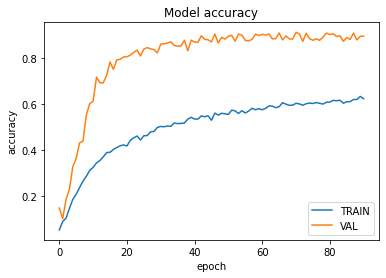

In [59]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

### Confusion Matrix

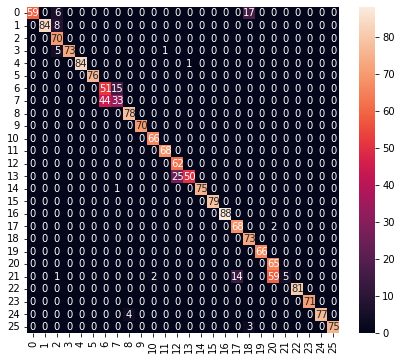

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.72      0.84        82
           1       1.00      0.91      0.95        92
           2       0.78      1.00      0.88        70
           3       1.00      0.92      0.96        79
           4       1.00      0.99      0.99        85
           5       1.00      1.00      1.00        76
           6       0.54      0.77      0.63        66
           7       0.67      0.43      0.52        77
           8       0.95      1.00      0.97        78
           9       1.00      1.00      1.00        70
          10       0.97      1.00      0.99        66
          11       0.99      1.00      0.99        68
          12       0.71      1.00      0.83        62
          13       0.98      0.67      0.79        75
          14       1.00      0.99      0.99        76
          15       1.00      1.00      1.00        79
          16       1.00      1.00      1.00        88
     

In [68]:
def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = tf_model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [69]:
loss, accuracy = tf_model.evaluate(X_test, y_test)

62/62 [==============================] - 0s 557us/step - loss: 0.4658 - accuracy: 0.8936


# TFLite Model Conversion

In [70]:
model.save(model_path, include_optimizer=False)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_right_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Shiv\AppData\Local\Temp\tmpmoghmbn7\assets


INFO:tensorflow:Assets written to: C:\Users\Shiv\AppData\Local\Temp\tmpmoghmbn7\assets


7392